In [2]:
import numpy as np

import matplotlib.pyplot as plt
#from scipy.integrate import odeint
#import mpmath as mpmath
#from scipy.optimize import linear_sum_assignment  # Hungarian algorithm 
import scipy

plt.rc('text', usetex=True)

# %matpnlotlib notebook 
%matplotlib inline 

import Husimi   # Quantum routines is used here! Uprop2 routine
#import Harp     # Classical integration routines
import importlib  # for reloading routines if you need to edit them

import pickle  # for storing python classes in binary files 


#### same as IPR_v01 except Ta has weaker perturbation strength
assuming this is the one that is up to date, ignore v01!

In [408]:
importlib.reload(Husimi)  # if you need to reload it!

<module 'Husimi' from '/Users/aquillen/Desktop/summer25/pylab/QDrift/Husimi.py'>

In [4]:
froot = 'IPR0_'
muprime = r'$\mu$' + '\''
twopi=2*np.pi

In [5]:
# return a list of random Haar distributed unitary matrices  in a 3d array N_u x N x N
# control case of unitaries, Haar uniformly distributed using scipy's routine
# which is based on F. Mezzadri, “How to generate random matrices from the classical compact groups”, arXiv:math-ph/0609050v2
# arguments:
#  N  dimension of matrices
#  N_u how many unitary matrices to compute
#  seed:  if you want the same random sequence, then pass an integer>0 as the seed 
# returns:
#  return a list of random Haar distributed unitary matrices  in a 3d array N_u x N x N
def Ulist_Harr(N,N_u,seed=None):
    Ulist = np.zeros((N_u, N,N), dtype = complex)
    if (seed == None):
        for k in range(N_u):
            U = scipy.stats.unitary_group.rvs(N)  #no seed
            Ulist[k,:,:] = U
    else:
        rs = np.random.RandomState(seed)
        for k in range(N_u):
            U = scipy.stats.unitary_group.rvs(N,random_state=rs)  # with a seed 
            Ulist[k,:,:] = U
    return Ulist


# compute qth inverse participation ratio for state psi
# using the basis given by vr 
# arguments:
#    q: index of IPR
#    vr: is a list of n orthonormal states  (a basis)
#     following eigenvectors from np.linalg.eig  in form vr[:,j] for jth eigenvector
#    psi: the state 
# computes I_q = sum_j |<j|psi>|^2q
def cIPR(q,vr,psi):
    N = vr.shape[0]
    iprsum  =0.0
    for j in range(N):
        jvec = np.squeeze(vr[:,j]) 
        dot_prod = np.vdot(jvec,psi)
        dot_prod2q = np.real(np.abs(dot_prod)**(2*q))  # magnitude square *q
        iprsum += dot_prod2q
    return iprsum

# compute a bunch of states U|psi0>  from a list of unitaries
# then take average of the qth inverse participation ratio from the list of states 
# imputs:  
#  q: index for IPR^q
#  vr : the basis used
#  Ulist : the list of unitaries
#  psi0 : the input state 
# returns an average ipr
# calls: cIPR
def mkIPR(q,vr,Ulist,psi0):
    Nu = Ulist.shape[0]
    iprsum = 0.0
    for k in range(Nu):
        U = np.squeeze(Ulist[k,:,:])
        psi = np.matmul(U,psi0)
        iprsum += cIPR(q,vr,psi)
    return iprsum/Nu

# for each U in a list of unitaries compute the iprq 
# return the list of iprq values 
# given a particular state psi0
# imputs:  
#  q: index for IPR^q
#  vr : the basis used
#  Ulist : the list of unitaries
#  psi0 : the input state 
# returns a list of iprs
# calls:  cIPR
def mk_IPR_list(q,vr,Ulist,psi0):
    Nu = Ulist.shape[0]
    iprq_list = np.zeros(Nu)
    for k in range(Nu):
        U = np.squeeze(Ulist[k,:,:])
     
        psi = np.matmul(U,psi0)
        iprq_list[k] = cIPR(q,vr,psi)
    return iprq_list  # these are all 1 if q=1 and Haar 


# using matrices of two sets of basis elements vr2, vr1 and a unitary matrix U
# computes values of |<vr2_j|U|vr1_i>|^2, returning the transition probabilities as a matrix 
def comp_ptrans_uUv(vr2,U,vr1):
    n = vr1.shape[0]
    t_matrix = np.zeros((n,n))  # for storing amplitudes^2 
    for i in range(n):
        v = np.squeeze(vr1[:,i]) # i-th eigenvector of first set
        for j in range(n):
            u = np.squeeze(vr2[:,j])  # j-th eigenvector of last set
            uUv = np.vdot(u,np.matmul(U,v))   # compute <u|U|v>
            t_matrix[i,j] = (np.absolute(uUv))**2  # compute magnitude^2 and put it in a matrix 
    return t_matrix  

In [668]:

# given desired min and max values for the histogram, and a maximum value of a list
# give us a set of bins good for a np histogram
# add the maximum of a list onto the bin array, useful for making histograms without truncation
def mkbinsarr(zmin,zmax,nbins,max_zlist):
    bins_arr = np.linspace(zmin,zmax,nbins)
    #max_zlist = np.max(zlist1)
    max_bin = max(max_zlist,zmax) + 0.01
    bins_arr = np.append(bins_arr,max_bin) 
    return bins_arr

# Porter-Thomas probability distribution (see for example Boixo+18, supplements I)
def f_PT(N,p):
    return (N-1)*np.power(1.0-p,N-2)
    # is approximately the same as N*np.exp(-N*p)
    
# cummulative version of the above 
# Porter-Thomas probability distribution (see for example Boixo+18, supplements I)
def cum_f_PT(N,p):
    return (1-np.exp(-N*p))
    # is approximately the same as N*np.exp(-N*p)

# just print out the first 3 moments of a list 
def perrs_short(zlist,prefix=''):
    N_z = len(zlist)
    mm_1 = np.mean(zlist);  sig_1 = np.std(zlist);  std_err_1 = sig_1/np.sqrt(N_z)
    z2list = zlist**2  # take the square for computing means k=2
    mm_2 = np.mean(z2list); sig_2 = np.std(z2list); std_err_2 = sig_2/np.sqrt(N_z)
    z3list = zlist**3  # take the cube for computing means k=3
    mm_3 = np.mean(z3list); sig_3 = np.std(z3list); std_err_3 = sig_3/np.sqrt(N_z)
    print(prefix,"mean z  ={:.3f} += {:.3f}, std z  = {:.2f}".format(mm_1, std_err_1, sig_1 ))
    print(prefix,"mean z2 ={:.3f} += {:.3f}, std z2 = {:.2f}".format(mm_2, std_err_2, sig_2 ))
    print(prefix,"mean z3 ={:.3f} += {:.3f}, std z3 = {:.2f}".format(mm_3, std_err_3, sig_3 ))
    mms = np.array([mm_1,mm_2,mm_3])
    sigs = np.array([sig_1,sig_2,sig_3])
    std_errs = np.array([std_err_1,std_err_2,std_err_3])
    return mms,sigs,std_errs

In [7]:
# check IPRs for pure state and uniform state 
N=41; N_u=100
#Ulist_Ha = Ulist_Harr(N,N_u)
vr_j = np.identity(N)
psi0 = np.zeros(N)
psi0 = psi0 + 1/np.sqrt(N)  # uniform state 
#psi0[15] = 1.0  # or just have a pure state 
q = 5 # works for any q
iprq = cIPR(q,vr_j,psi0)
print(iprq,N**(1-q))  # passes test for uniform distribution and for single state 

3.538869706249042e-07 3.5388697062490424e-07


In [8]:
# check IPRs for Haar states 
N=51; N_u=400
Ulist_Ha = Ulist_Harr(N,N_u)
vr_j = np.identity(N)
psi0 = np.zeros(N)
psi0[4] = 1
q = 2
iprq = mkIPR(q,vr_j,Ulist_Ha,psi0)  # single state 
qfactorial = scipy.special.factorial(q)
print(iprq, qfactorial* np.power(float(N),(1-q)))   # is approximately haar correct for q>2
# note this is the Haar value of the ipr!

# Haar value averaged over Haar unitaries is supossed to be q! N^(1-q) eqn 22 by Claeys+24
# our computed values seems a bit low 

0.038195582208644975 0.0392156862745098


In [422]:
# show cumulative distributions for 2 sets of probabilities
# meant to be used with transition probabilities 
# assuming that vprobs1 is Harr and vprobs2 is not
# we also plot the distribution expected for PT
def mk_cumfig(N,vprobs1,vprobs2,ofile=None,basislabel = None,toplabel=None,ablabel=None,Ulabel=''):
    fig,ax = plt.subplots(1,1,figsize=(2.5,2.2),dpi=350)
    plt.subplots_adjust(left=0.26,bottom=0.22,top=0.97,right=0.97)
    xmin=0.0; xmax = 0.1

    style3 = {'facecolor': 'blue', 'linewidth': 1, 'linestyle':'solid'}
    style1 = {'facecolor': 'red', 'edgecolor': 'purple', 'linewidth': 0, 'linestyle':'solid'}
    bins_arr = mkbinsarr(xmin,xmax,100,np.max(vprobs1))
    ax.hist(vprobs1,bins=bins_arr,density=True,cumulative=True,alpha=0.7,\
            histtype='step',**style3,label=r'$\hat U_{\rm Haar}$')  
    bins_arr2 = mkbinsarr(xmin,xmax,100,np.max(vprobs2))
    ax.hist(vprobs2,bins=bins_arr,density=True,cumulative=True,alpha=0.3,\
            histtype='stepfilled',**style1,label=Ulabel)  
    ax.set_xlim([xmin,xmax])
    xarr = np.linspace(xmin,xmax,100)
    fpt = cum_f_PT(N,xarr)
    ax.plot(xarr,fpt,'k-',lw=1,label=r'1-$e^{-Np}$',alpha=0.5)
    ax.set_ylabel('cumulative histogram',fontsize=12,labelpad=2)
    ax.set_xlabel('transition probablity',fontsize=12,labelpad=2)
    #ax.hist(vprobs,bins=50)
    ax.legend(borderpad=0.3,handlelength=1.2,handletextpad=0.5,fontsize=12,labelspacing=0.1)
    if (ablabel!= None):
        ax.text(-0.035,1.02,ablabel,fontsize=12)
    if (toplabel!= None):
        if (ablabel == None):
            ax.text(0.023,0.55,toplabel,fontsize=11)
        else:
            if (ablabel =='d)'):
                ax.text(0.023,0.55,toplabel,fontsize=10)
            else:
                ax.text(0.023,0.55,toplabel,fontsize=11)
            
    if (basislabel!= None):
        ax.text(0.04,0.85,basislabel,fontsize=12)
    if (ofile != None):
        plt.savefig(ofile)
    
    plt.show()  # yup it looks exponential 

In [673]:
# a class to store information about a regular propagator 
class probs_cls():
    def __init__(self,N,a,b,eps,mu,mup,taushift=0,phishift=0):
        self.N = N
        self.ntau = N*4
        self.a = a
        self.b = b
        self.eps = eps
        self.mu = mu
        self.mup= mup
        self.taushift = taushift
        self.phishift = phishift

        # compute propagator 
        w,vr,U = Husimi.U_prop2(N,self.ntau,a,b,eps,mu,mup,self.taushift,phishift=self.phishift) 
        self.w = w
        self.vr = vr
        self.U = U  # non-drifted operator

        # h0 basis 
        w_h0,vr_h0 = Husimi.h0_eigs(self.N,self.a,self.b,self.eps) 
        #self.wsort = wsort
        self.vr_h0 = vr_h0  # h0 basis
        
        self.vr_j = np.identity(self.N)  # conventional basis 

        # Haar matrix
        self.U_Ha = scipy.stats.unitary_group.rvs(self.N) # single matrix, randomly chosen from Haar

        if (self.N <= 100):

            # compute transition probs using vr_j basis 
            self.vprobs_UT = np.ravel(comp_ptrans_uUv(self.vr_j,self.U,self.vr_j))  # turn into 1d array
            self.vprobs_Ha = np.ravel(comp_ptrans_uUv(self.vr_j,self.U_Ha,self.vr_j))  # turn into 1d array
            self.vprobs_UT_mms,self.vprobs_UT_sigs,self.vprobs_UT_std_errs = \
                perrs_short(self.N*self.vprobs_UT,prefix='Bj probs UT')
            self.vprobs_Ha_mms,self.vprobs_Ha_sigs,self.vprobs_Ha_std_errs = \
                perrs_short(self.N*self.vprobs_Ha,prefix='Bj probs UHa')
            
            # compute transition probs using vr_h0 basis 
            self.vprobs_UT_h0 = np.ravel(comp_ptrans_uUv(self.vr_h0,self.U,self.vr_h0))  # turn into 1d array
            self.vprobs_Ha_h0 = np.ravel(comp_ptrans_uUv(self.vr_h0,self.U_Ha,self.vr_h0))  # turn into 1d array
            self.vprobs_UT_h0_mms,self.vprobs_UT_h0_sigs,self.vprobs_UT_h0_std_errs = \
                perrs_short(self.N*self.vprobs_UT_h0,prefix='Bh0 probs UT')
            self.vprobs_Ha_h0_mms,self.vprobs_Ha_h0_sigs,self.vprobs_Ha_h0_std_errs = \
                perrs_short(self.N*self.vprobs_Ha_h0,prefix='Bh0 probs UHa')
    
            # compute inverse participation ratios q=2 q=3 in j basis of Haar matrix 
            self.iprlist_Ha_j2 = IPR_U(2,self.vr_j,self.U_Ha)
            self.iprlist_Ha_j3 = IPR_U(3,self.vr_j,self.U_Ha)
            self.iprlist_Ha_h2 = IPR_U(2,self.vr_h0,self.U_Ha)  # in h0 basis
            self.iprlist_Ha_h3 = IPR_U(3,self.vr_h0,self.U_Ha)

            # compute inverse participation ratios q=2 q=3 in j basis of propagator 
            self.iprlist_j2 = IPR_U(2,self.vr_j,self.U)
            self.iprlist_j3 = IPR_U(3,self.vr_j,self.U)
            self.iprlist_h2 = IPR_U(2,self.vr_h0,self.U) # in h0 basis
            self.iprlist_h3 = IPR_U(3,self.vr_h0,self.U)

# a class to store information about a drifted propagator 
class var_cls():
    def __init__(self,N,parms0,d_parms,tau0=0,nperiods=1,phishift=0):
        self.N = N
        self.parms0 = parms0
        self.d_parms = d_parms
        self.tau0 = tau0
        self.nperiods = nperiods
        self.phishift = phishift
        self.ntau = 4*N
        # compute the propagator
        w_var,vr_var,U_var = Husimi.U_prop2_var(N,self.ntau,parms0,d_parms,tau0,nperiods,phishift=phishift)
        self.w = w_var
        self.vr = vr_var
        self.U = U_var

        self.a0 = parms0[0]
        self.b0 = parms0[1]
        self.eps0 = parms0[2]
        wsort,vr_h0 = Husimi.h0_eigs(self.N,self.a0,self.b0,self.eps0) 
        self.vr_h0 = vr_h0  # h0 basis
        self.vr_j = np.identity(self.N)  # conventional basis 

        self.end_parms = self.parms0 + self.d_parms * 2*np.pi *self.nperiods

        self.U_Ha = scipy.stats.unitary_group.rvs(self.N) # single matrix, randomly chosen from Haar

        # compute transition probabilities in the two bases
        self.vprobs_UT = np.ravel(comp_ptrans_uUv(self.vr_j,self.U,self.vr_j))  # turn into 1d array
        self.vprobs_Ha = np.ravel(comp_ptrans_uUv(self.vr_j,self.U_Ha,self.vr_j))  
        self.vprobs_UT_h0 = np.ravel(comp_ptrans_uUv(self.vr_h0,self.U,self.vr_h0)) 

        self.vprobs_UT_mms,self.vprobs_UT_sigs,self.vprobs_UT_std_errs = \
            perrs_short(self.N*self.vprobs_UT,prefix='Bj probs UT')
        self.vprobs_UT_h0_mms,self.vprobs_UT_h0_sigs,self.vprobs_UT_h0_std_errs = \
            perrs_short(self.N*self.vprobs_UT_h0,prefix='Bh0 probs UT')

        # compute inverse participation ratios in j basis of Haar matrix
        self.iprlist_Ha_j2 = IPR_U(2,self.vr_j,self.U_Ha)
        self.iprlist_Ha_j3 = IPR_U(3,self.vr_j,self.U_Ha)
        self.iprlist_Ha_h2 = IPR_U(2,self.vr_h0,self.U_Ha)  # in h0 basis 
        self.iprlist_Ha_h3 = IPR_U(3,self.vr_h0,self.U_Ha)

        # compute inverse participation ratios in j basis of propagator matrix
        self.iprlist_j2 = IPR_U(2,self.vr_j,self.U)
        self.iprlist_j3 = IPR_U(3,self.vr_j,self.U)

        # compute inverse participation ratios in h0 basis of propagator matrix
        self.iprlist_h2 = IPR_U(2,self.vr_h0,self.U)
        self.iprlist_h3 = IPR_U(3,self.vr_h0,self.U)

        #parms0 = np.array([a0,b0,eps0,mu0,mup0])
        #d_parms = np.array([0.0,db,0.0,dmu,dmup])

# for a basis given by vr, compute inverse particitpation ratios generated from U|v> in this basis 
# arguments:
#   q index for ipr
#   vr a set of orthonormal basis vectors 
#   U a unitary matrix 
# returns inverse participation ratios computed for all states U|j> for each j in basis and using vr basis
def IPR_U(q,vr,U):
    N =vr.shape[0]
    iprlist = np.zeros(N)
    for j in range(N):
        vj = np.squeeze(vr[:,j])
        psi = np.matmul(U,vj)
        iprlist[j] = cIPR(q,vr,psi)
    return iprlist



In [360]:
def plt3_trans(vr,U_Ta,U_Tb,U_Tc,l1=None,l2=None,l3=None,balabel=None,ablabel=None):
    N = vr.shape[0]
    vmax = 1/np.sqrt(N)
    fig,axarr = plt.subplots(1,3,figsize=(6,3))
    plt.subplots_adjust(hspace=0,wspace=0,left=0.01,right=0.99,top=0.95,bottom =0.01)
    for j in range(3):
        axarr[j].set_xticks([])
        axarr[j].set_yticks([])
    axarr[0].imshow(comp_ptrans_uUv(vr,U_Ta,vr),origin='lower',vmin=0,vmax=vmax)
    axarr[1].imshow(comp_ptrans_uUv(vr,U_Tb,vr),origin='lower',vmin=0,vmax=vmax)
    axarr[2].imshow(comp_ptrans_uUv(vr,U_Tc,vr),origin='lower',vmin=0,vmax=vmax)
    if (l1 != None):
        axarr[0].text(0,N,l1)
    if (l2 != None):
        axarr[1].text(0,N,l2)
    if (l3 != None):
        axarr[2].text(0,N,l3)
    plt.show()

# plot images of transition matrices from 4 unitaries, using basis vr
def plt4_trans(vr,U_Ta,U_Tb,U_Tc,U_Td,l1=None,l2=None,l3=None,l4=None,balabel=None,ablabel=None,baselabel=None,ofile=None):
    N = vr.shape[0]
    vmax = 1/np.sqrt(N)
    fig,axarr = plt.subplots(1,4,figsize=(7,2.3),dpi=250)
    plt.subplots_adjust(hspace=0,wspace=0,left=0.04,right=0.99,top=0.95,bottom =0.01)
    for j in range(4):
        axarr[j].set_xticks([])
        axarr[j].set_yticks([])
    axarr[0].imshow(comp_ptrans_uUv(vr,U_Ta,vr),origin='lower',vmin=0,vmax=vmax)
    axarr[1].imshow(comp_ptrans_uUv(vr,U_Tb,vr),origin='lower',vmin=0,vmax=vmax)
    axarr[2].imshow(comp_ptrans_uUv(vr,U_Tc,vr),origin='lower',vmin=0,vmax=vmax)
    axarr[3].imshow(comp_ptrans_uUv(vr,U_Td,vr),origin='lower',vmin=0,vmax=vmax)
    xl = 0.04; yl=1.03
    if (l1 != None):
        axarr[0].text(xl,yl,l1, transform = axarr[0].transAxes,fontsize=14)
    if (l2 != None):
        axarr[1].text(xl,yl,l2, transform = axarr[1].transAxes,fontsize=14)
    if (l3 != None):
        axarr[2].text(xl,yl,l3, transform = axarr[2].transAxes,fontsize=14)
    if (l4 != None):
        axarr[3].text(xl,yl,l4, transform = axarr[3].transAxes,fontsize=14)
    if (ablabel != None):
        axarr[0].text(-0.10,1.02,ablabel,transform = axarr[0].transAxes,fontsize=16)
    if (balabel != None):
        axarr[0].text(0.1,0.03,balabel, transform = axarr[0].transAxes,color='red',fontsize=15,ha='left')
    if (baselabel != None):
        axarr[0].text(0.01,-0.07,baselabel, transform = axarr[0].transAxes,color='blue',fontsize=14,ha='left')
    if (ofile != None):
        plt.savefig(ofile)
    plt.show()



Bj probs UT mean z  =1.000 += 0.015, std z  = 1.20
Bj probs UT mean z2 =2.437 += 0.091, std z2 = 7.37
Bj probs UT mean z3 =10.127 += 0.774, std z3 = 62.66
Bj probs UHa mean z  =1.000 += 0.012, std z  = 0.98
Bj probs UHa mean z2 =1.965 += 0.050, std z2 = 4.01
Bj probs UHa mean z3 =5.557 += 0.240, std z3 = 19.48
Bh0 probs UT mean z  =1.000 += 0.015, std z  = 1.21
Bh0 probs UT mean z2 =2.475 += 0.104, std z2 = 8.41
Bh0 probs UT mean z3 =10.957 += 1.220, std z3 = 98.85
Bh0 probs UHa mean z  =1.000 += 0.012, std z  = 0.99
Bh0 probs UHa mean z2 =1.979 += 0.054, std z2 = 4.34
Bh0 probs UHa mean z3 =5.812 += 0.309, std z3 = 25.00


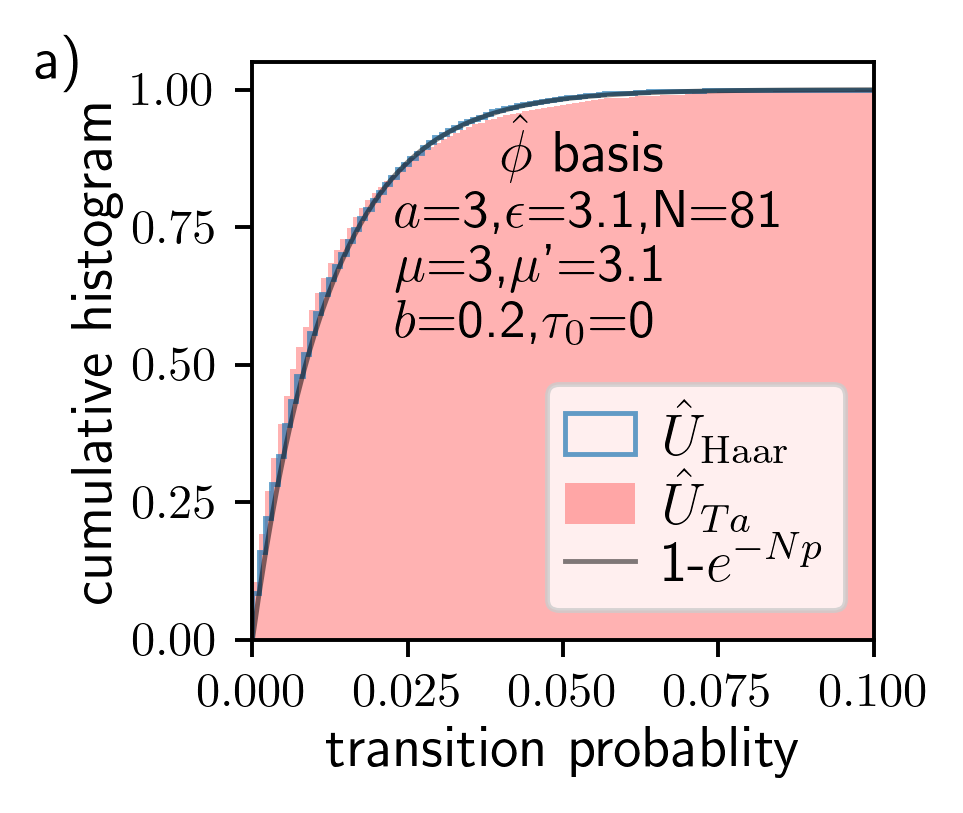

In [674]:
N=81; a = 3; b=0.2; eps = 3.1; mu = 3; mup = 3.1
cla_Ta = probs_cls(N,a,b,eps,mu,mup)

phi_basis_text =  r'$\hat \phi$ basis' 

toplabel = '$a$={:.0f},'.format(a) + r'$\epsilon$={:.1f},'.format(eps)  
toplabel += 'N={:d}'.format(N)+ '\n'
toplabel += r'$\mu$={:.0f},'.format(mu) + muprime +  '={:.1f}'.format(mup) + '\n'
toplabel += r'$b$={:.1f},'.format(b) + r'$\tau_0$=0'
cla_Ta.toplabel = toplabel

ofile_a = froot + 'chist_jj.png'
mk_cumfig(cla_Ta.N,cla_Ta.vprobs_Ha,cla_Ta.vprobs_UT,ofile=ofile_a,toplabel=cla_Ta.toplabel,basislabel=phi_basis_text,\
          ablabel='a)',Ulabel=r'$\hat U_{Ta}$')


Bj probs UT mean z  =1.000 += 0.019, std z  = 1.57
Bj probs UT mean z2 =3.479 += 0.163, std z2 = 13.21
Bj probs UT mean z3 =21.685 += 1.871, std z3 = 151.52
Bj probs UHa mean z  =1.000 += 0.012, std z  = 0.99
Bj probs UHa mean z2 =1.974 += 0.056, std z2 = 4.57
Bj probs UHa mean z3 =5.918 += 0.393, std z3 = 31.81
Bh0 probs UT mean z  =1.000 += 0.040, std z  = 3.25
Bh0 probs UT mean z2 =11.589 += 1.509, std z2 = 122.26
Bh0 probs UT mean z3 =345.867 += 82.240, std z3 = 6661.43
Bh0 probs UHa mean z  =1.000 += 0.012, std z  = 0.99
Bh0 probs UHa mean z2 =1.983 += 0.054, std z2 = 4.34
Bh0 probs UHa mean z3 =5.846 += 0.296, std z3 = 23.96


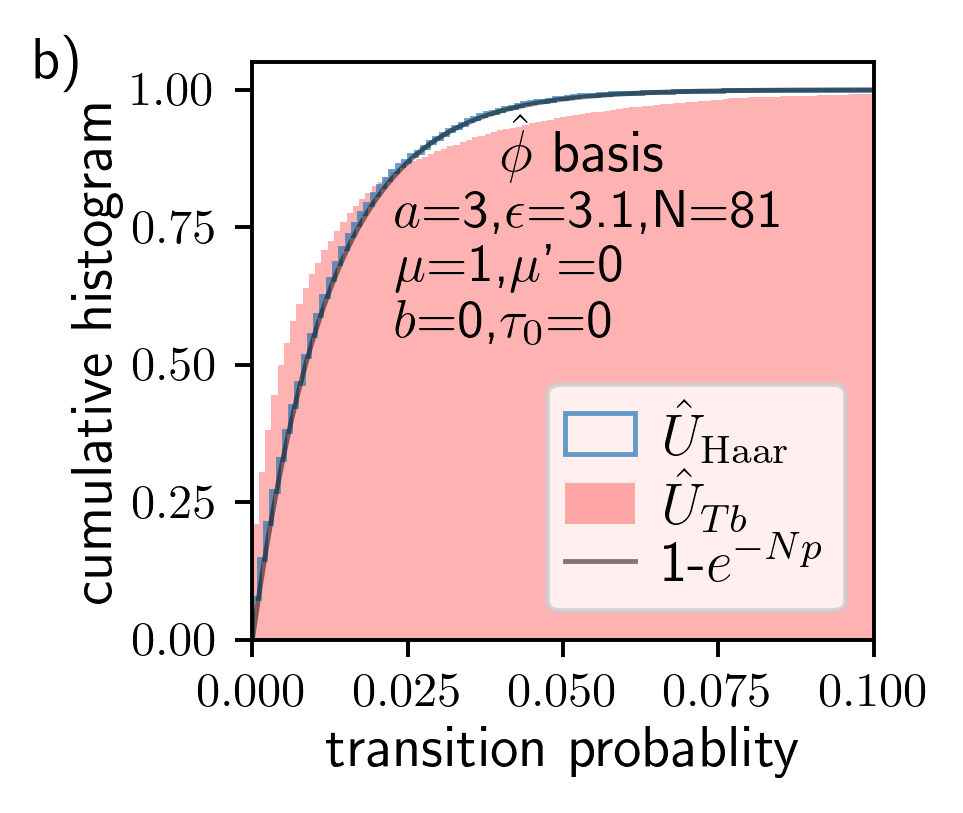

In [675]:
# look at a less-chaotic system 

N=81; a = 3; b=0.0; eps = 3.1; mu = 1; mup = 0.
cla_Tb = probs_cls(N,a,b,eps,mu,mup)

phi_basis_text = r'$\hat \phi$ basis' 

toplabel = '$a$={:.0f},'.format(a) + r'$\epsilon$={:.1f},'.format(eps)  
toplabel += 'N={:d}'.format(N)+ '\n'
toplabel += r'$\mu$={:.0f},'.format(mu) + muprime +  '={:.0f}'.format(mup) + '\n'
toplabel += r'$b$={:.0f},'.format(b) + r'$\tau_0$=0'
cla_Tb.toplabel = toplabel

ofile_b = froot + 'chist_jj2.png'
mk_cumfig(cla_Tb.N,cla_Tb.vprobs_Ha,cla_Tb.vprobs_UT,ofile=ofile_b,toplabel=cla_Tb.toplabel,basislabel=phi_basis_text,\
          ablabel='b)',Ulabel = r'$\hat U_{Tb}$')

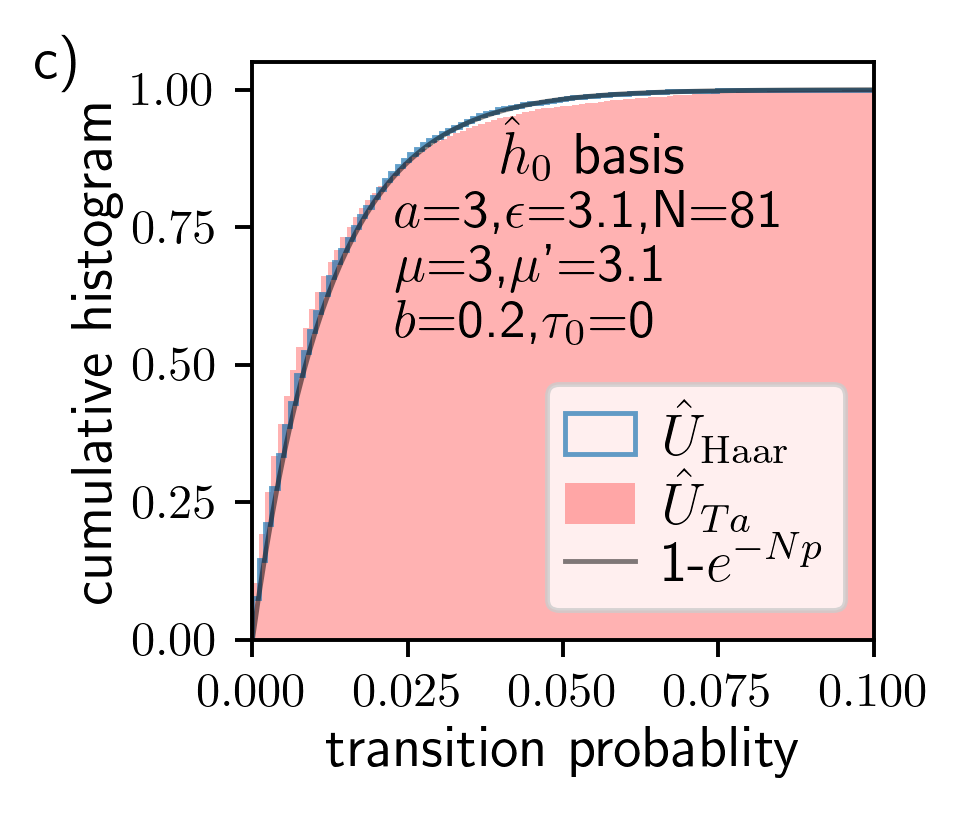

In [425]:
h0_basis_text =  r'$\hat h_0$ basis'  
ofile_c = froot + 'chist_h0.png'
mk_cumfig(cla_Ta.N,cla_Ta.vprobs_Ha_h0,cla_Ta.vprobs_UT_h0,ofile=ofile_c,toplabel=cla_Ta.toplabel,basislabel=h0_basis_text,\
          ablabel='c)',Ulabel = r'$\hat U_{Ta}$')


Bj probs UT mean z  =1.000 += 0.012, std z  = 0.98
Bj probs UT mean z2 =1.967 += 0.052, std z2 = 4.18
Bj probs UT mean z3 =5.679 += 0.267, std z3 = 21.65
Bh0 probs UT mean z  =1.000 += 0.012, std z  = 1.01
Bh0 probs UT mean z2 =2.023 += 0.060, std z2 = 4.84
Bh0 probs UT mean z3 =6.332 += 0.388, std z3 = 31.42


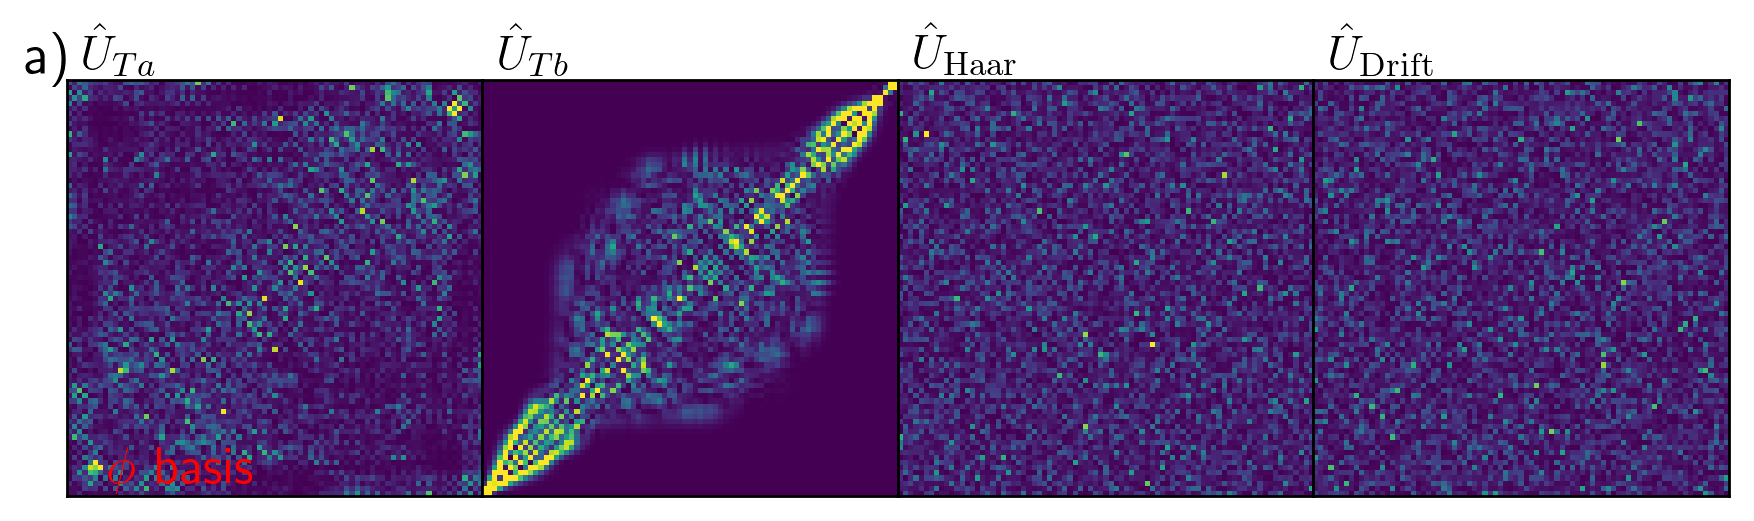

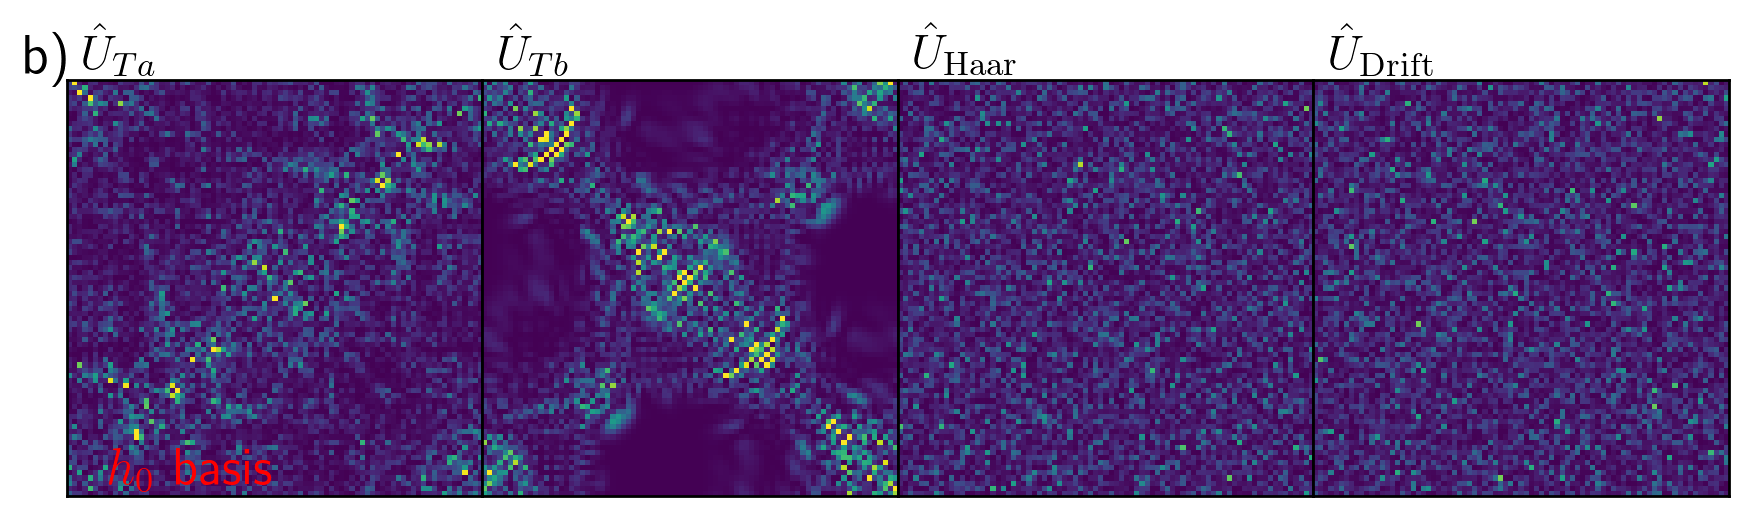

In [676]:
N=81
nperiods = 3
tau0 = 0 
a0 = 3;  b0=0.0; eps0 = 3.0; mu0 = 1; mup0 = 0.5
db = 0.1
dmu = 2/twopi
dmup = 2/twopi
parms0 = np.array([a0,b0,eps0,mu0,mup0])
d_parms = np.array([0.0,db,0.0,dmu,dmup])

var_1 = var_cls(N,parms0,d_parms,tau0=tau0,nperiods=nperiods,phishift=0)
#w_var_a,vr_var,U_var_a = Husimi.U_prop2_var(N,4*N,parms0,d_parms,tau0,nperiods,phishift=0)

# show transition matrices 
ofile = froot + 'tt_jj.png'
plt4_trans(cla_Ta.vr_h0, cla_Ta.U, cla_Tb.U,cla_Ta.U_Ha,var_1.U,\
           l1=r'$\hat U_{Ta}$',l2=r'$\hat U_{Tb}$',l3=r'$\hat U_{\rm Haar}$',l4=r'$\hat U_{\rm Drift}$',\
           balabel=r'$\phi$ basis',ablabel='a)',ofile=ofile )
ofile = froot + 'tt_h0.png'
plt4_trans(cla_Ta.vr_j,  cla_Ta.U, cla_Tb.U,cla_Ta.U_Ha,var_1.U,\
           l1=r'$\hat U_{Ta}$',l2=r'$\hat U_{Tb}$',l3=r'$\hat U_{\rm Haar}$',l4=r'$\hat U_{\rm Drift}$',\
           balabel=r'$h_0$ basis',ablabel='b)',ofile=ofile)

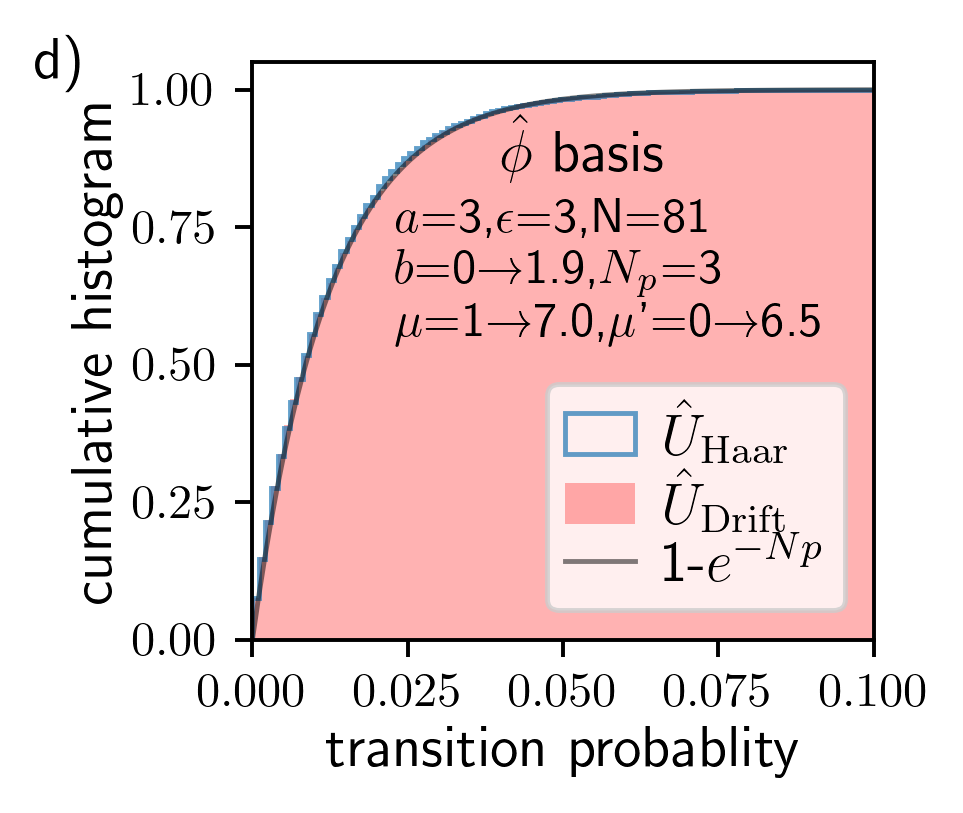

In [426]:
toplabel =  r'$a$={:.0f},'.format(var_1.parms0[0])
toplabel += r'$\epsilon$={:.0f},'.format(var_1.parms0[2])
toplabel += 'N={:d}'.format(var_1.N)+ '\n'
toplabel += r'$b$={:.0f}'.format(var_1.parms0[1]) 
toplabel += '\u2192'
toplabel += '{:.1f}'.format(var_1.end_parms[1]) 
toplabel += ',' + r'$N_{p}$'+ '={:0d}'.format(var_1.nperiods) + '\n'
toplabel += r'$\mu$={:.0f}'.format(var_1.parms0[3]) 
toplabel += '\u2192'
toplabel += '{:.1f},'.format(var_1.end_parms[3]) 
toplabel += r'$\mu$' + '\'' + '={:.0f}'.format(var_1.parms0[4]) 
toplabel += '\u2192'
toplabel += '{:.1f}'.format(var_1.end_parms[4]) 
var_1.toplabel = toplabel

#parms0 = np.array([a0,b0,eps0,mu0,mup0])
#d_parms = np.array([0.0,db,0.0,dmu,dmup])

ofile_d = froot + 'chist_varjj.png'
mk_cumfig(var_1.N,var_1.vprobs_Ha,var_1.vprobs_UT,ofile=ofile_d,toplabel=toplabel,basislabel=phi_basis_text,\
          ablabel='d)',Ulabel = r'$\hat U_{\rm Drift}$')


In [378]:
print(var_1.end_parms)

[3.         1.88495559 3.         7.         6.5       ]


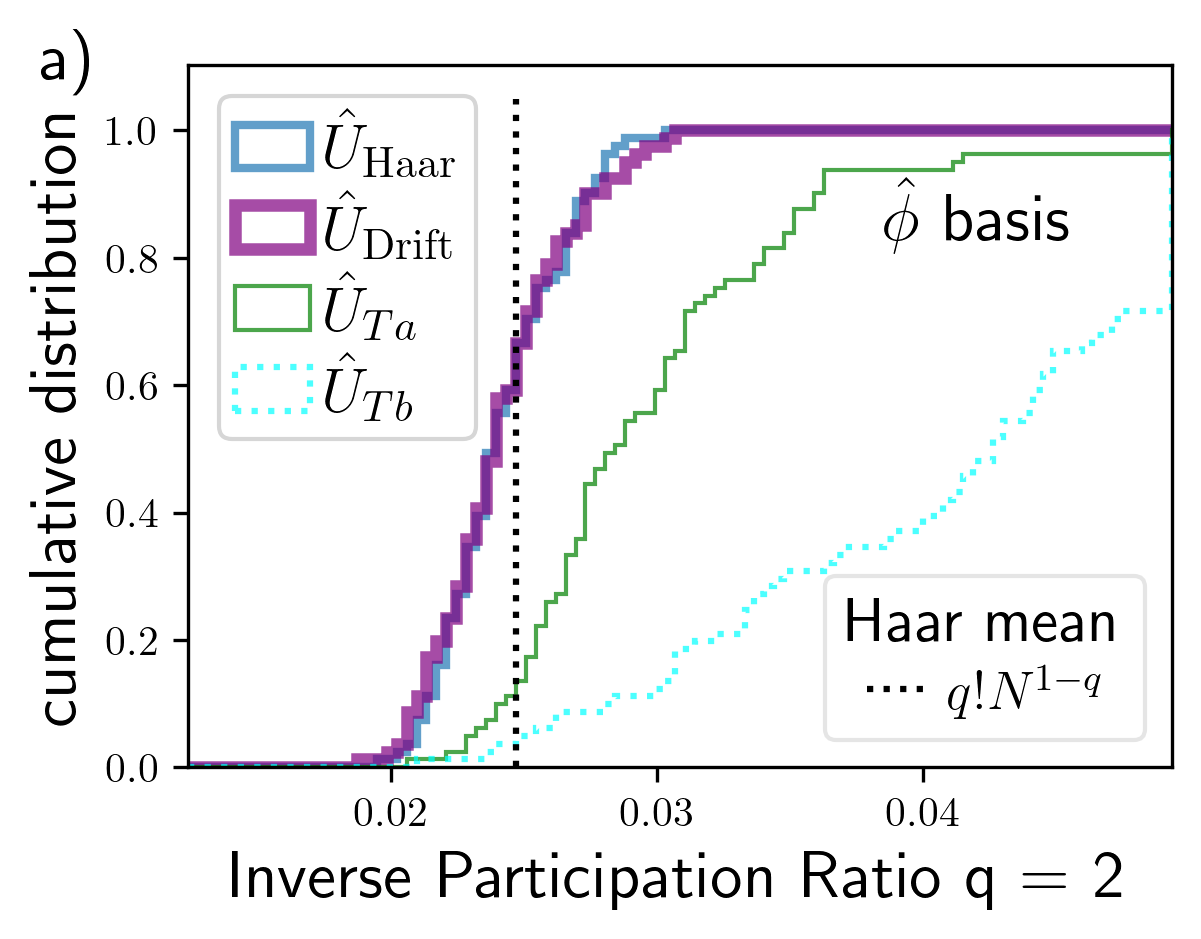

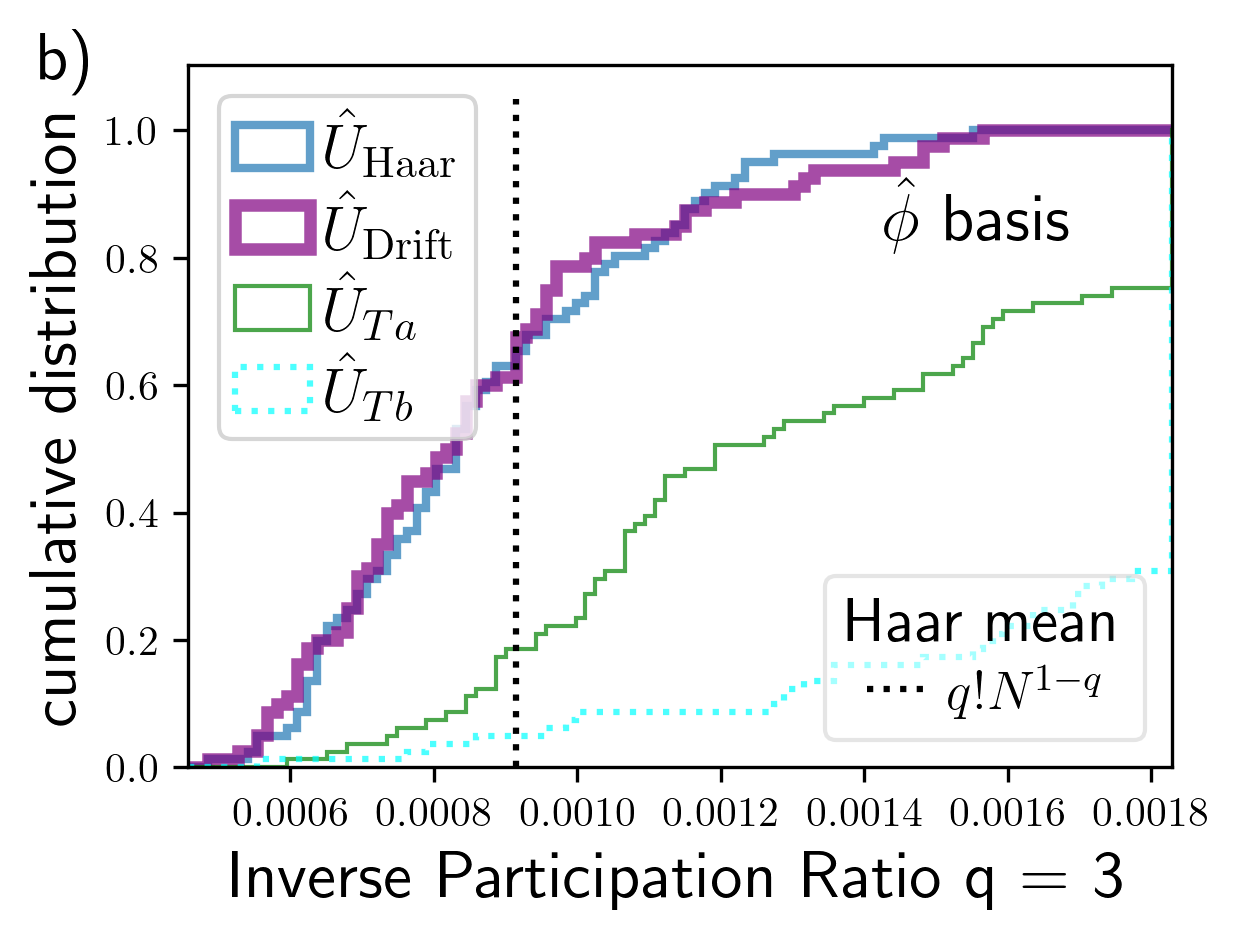

In [395]:
# show cumulative histograms of inverse participation ratios 
def mkqfig(q,N,vprobs1,vprobs2,vprobs3,vprobs4,fac,ablabel=None,basislabel=None,ofile=None):
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=300)
    plt.subplots_adjust(left=0.15,right=0.97,top=0.96,bottom=0.18)
    qfactorial = scipy.special.factorial(q)
    ipr_Haar = qfactorial* np.power(float(N),(1-q))
    ipr_Harr_label = r'$q! N^{1-q}$'
    xmin = ipr_Haar /fac; 
    xmax = fac*ipr_Haar 
    bins_arr1 = mkbinsarr(xmin,xmax,100,np.max(vprobs1))
    bins_arr2 = mkbinsarr(xmin,xmax,100,np.max(vprobs2))
    bins_arr3 = mkbinsarr(xmin,xmax,100,np.max(vprobs3))
    bins_arr4 = mkbinsarr(xmin,xmax,100,np.max(vprobs4))
    ax.set_xlim([xmin,xmax])

    style1 = {'facecolor': 'blue', 'linewidth': 2, 'linestyle':'solid'}
    style2 = {'facecolor': 'red',   'edgecolor': 'purple', 'linewidth': 3, 'linestyle':'solid'}
    style3 = {'facecolor': 'green', 'edgecolor': 'green', 'linewidth': 1, 'linestyle':'solid'}
    style4 = {'facecolor': 'cyan', 'edgecolor': 'cyan', 'linewidth': 1.5, 'linestyle':'dotted'}
    
    ax.hist(vprobs1,bins=bins_arr1,density=True,cumulative=True,alpha=0.7,\
            histtype='step',**style1,label=r'$\hat U_{\rm Haar}$')  
    ax.hist(vprobs2,bins=bins_arr2,density=True,cumulative=True,alpha=0.7,\
            histtype='step',**style2,label=r'$\hat U_{\rm Drift}$')  
    ax.hist(vprobs3,bins=bins_arr3,density=True,cumulative=True,alpha=0.7,\
            histtype='step',**style3,label=r'$\hat U_{Ta}$') 
    ax.hist(vprobs4,bins=bins_arr4,density=True,cumulative=True,alpha=0.7,\
            histtype='step',**style4,label=r'$\hat U_{Tb}$') 

    first_legend = ax.legend(borderpad=0.25,handlelength=1.2,handletextpad=0.25,fontsize=15,labelspacing=0.2)
    ax.add_artist(first_legend)
    ax.set_xlabel('Inverse Participation Ratio' + ' q = {:d}'.format(q),fontsize=16)
    ax.set_ylabel('cumulative distribution',fontsize=16)
    
    [y1,y2] = ax.get_ylim()
    handles = []
    lww,=ax.plot([ipr_Haar,ipr_Haar],[y1,y2],'k:',label=ipr_Harr_label)
    handles.append(lww)
    second_legend = ax.legend(handles=handles, loc='lower right',labelspacing=0.2, \
                              handlelength=1.2,title=r'Haar mean',title_fontsize=15,fontsize=13,framealpha=0.5,handletextpad=0.3)

    if (ablabel != None):
        ax.text(-0.15,0.98,ablabel,transform = ax.transAxes,fontsize=16)
    if (basislabel != None):
        ax.text(0.9,0.75,basislabel,transform = ax.transAxes,fontsize=16,ha='right')
    if (ofile != None):
        plt.savefig(ofile)
    plt.show()

phi_basis_text = r'$\hat \phi$ basis'
ofile = froot + 'q2.png'
mkqfig(2,cla_Ta.N,cla_Ta.iprlist_Ha_j2,var_1.iprlist_j2,cla_Ta.iprlist_j2,cla_Tb.iprlist_j2,2,ablabel='a)',\
       basislabel=phi_basis_text, ofile=ofile)
ofile = froot + 'q3.png'
mkqfig(3,cla_Ta.N,cla_Ta.iprlist_Ha_j3,var_1.iprlist_j3,cla_Ta.iprlist_j3,cla_Tb.iprlist_j3,2,ablabel='b)',\
       basislabel=phi_basis_text, ofile=ofile)

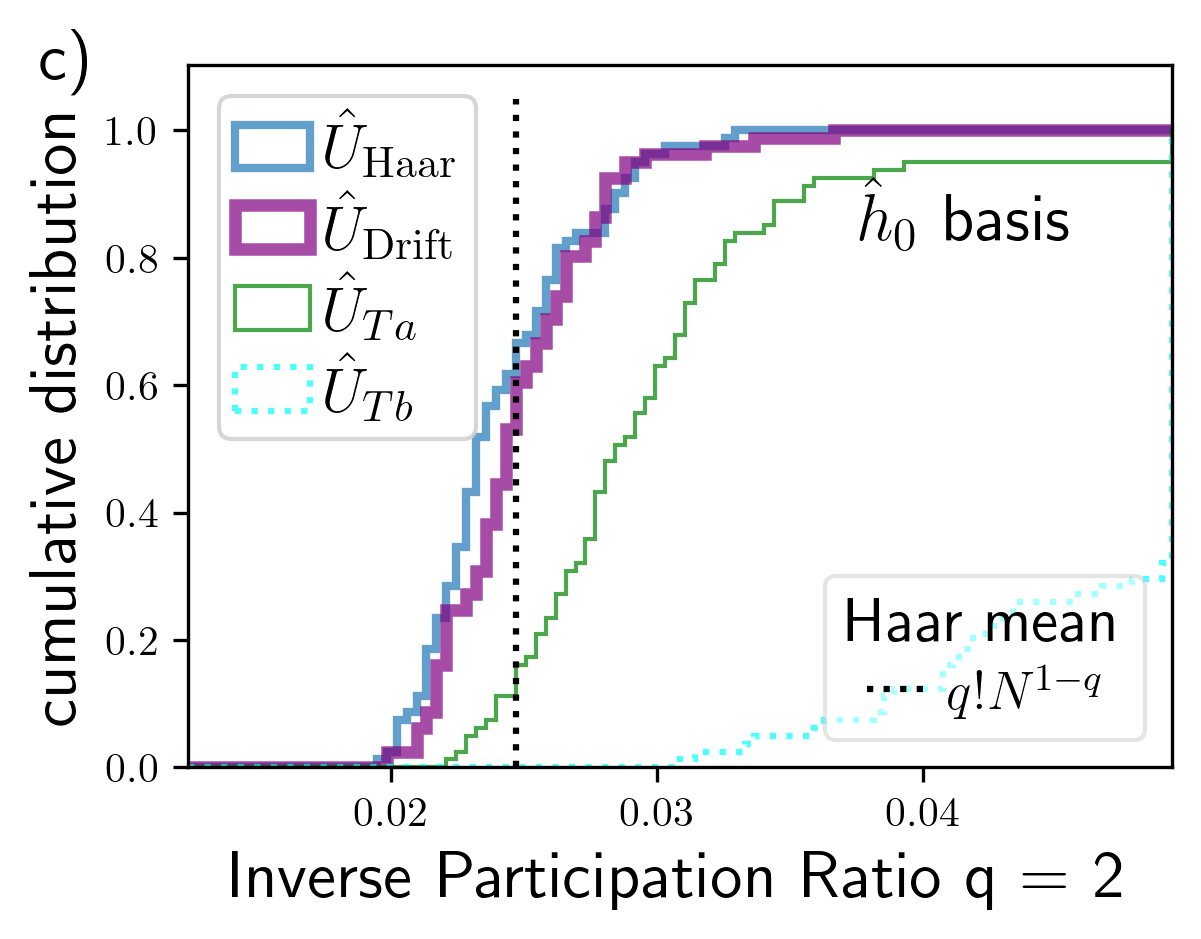

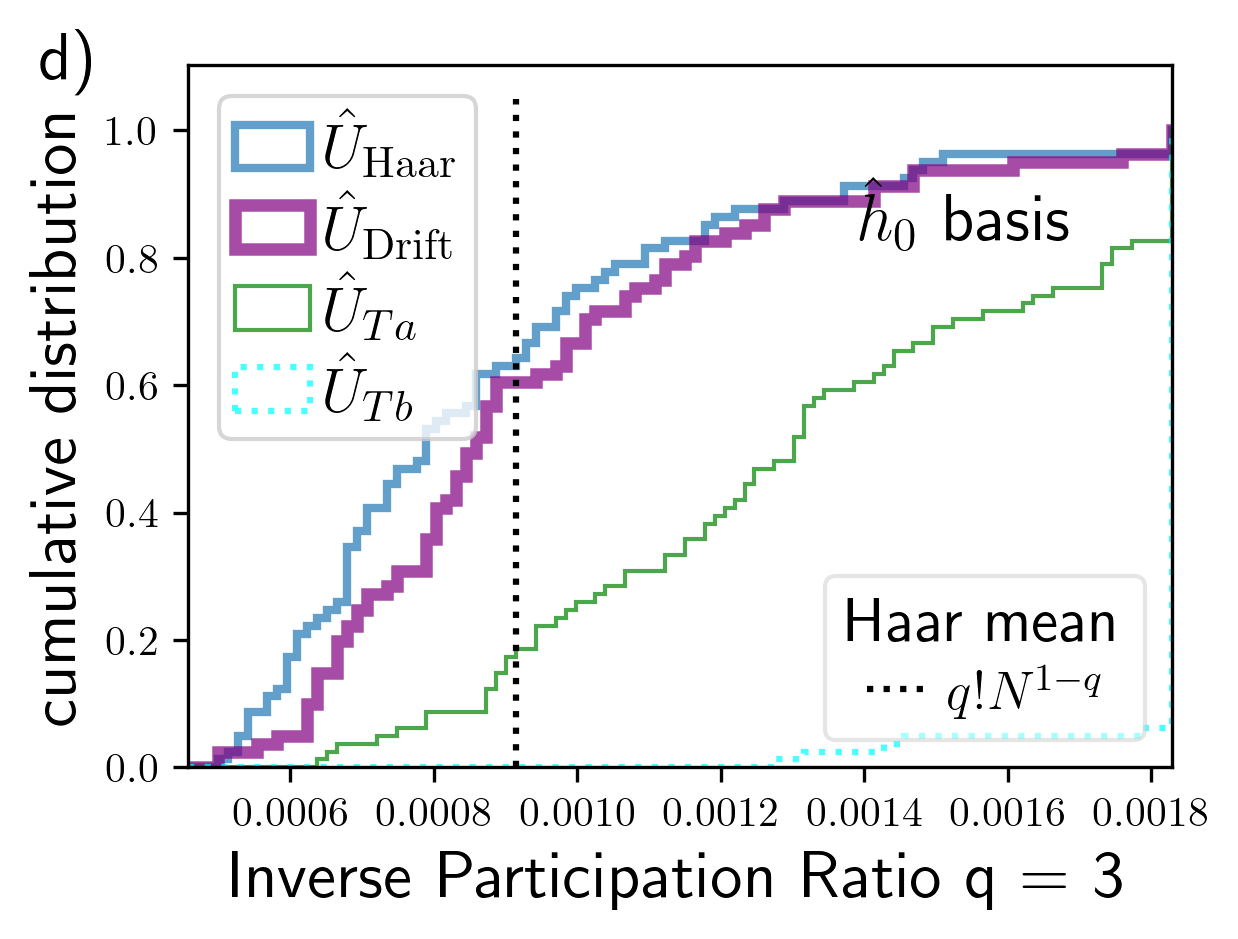

In [396]:
h0_basis_text = r'$\hat h_0$ basis'
ofile = froot + 'q2_h0.png'
mkqfig(2,cla_Ta.N,cla_Ta.iprlist_Ha_h2,var_1.iprlist_h2,cla_Ta.iprlist_h2,cla_Tb.iprlist_h2,2,ablabel='c)',\
       basislabel=h0_basis_text, ofile=ofile)
ofile = froot + 'q3_h0.png'
mkqfig(3,cla_Ta.N,cla_Ta.iprlist_Ha_h3,var_1.iprlist_h3,cla_Ta.iprlist_h3,cla_Tb.iprlist_h3,2,ablabel='d)',\
       basislabel=h0_basis_text, ofile=ofile)

In [209]:
# computing 1/sqrt(N) tr D_kl^dagger W = w_kl
# these are coefficients in displacement operator basis 
# W is an operator 
def W_Disptrans(W):
    N = W.shape[0]
    Wvals = np.zeros((N,N),dtype=complex)
    for k in range(N):
        for l in range(N):
            Dhat_dagger = Husimi.Displacement_op(N,N-k,N-l)  # omega^-kl/2 Z-k X-l
            Wdagger = np.conj(W).T
            DW = np.matmul(Dhat_dagger,Wdagger)
            Wvals[k,l] = np.trace(DW)
    Wvals /= np.sqrt(N)
    return Wvals  # returns a matrix of values   # takes a while!  these are complex numbers 
            
Wvals_Ha = W_Disptrans(cla_Ta.U_Ha)

In [211]:
Wvals_Ta = W_Disptrans(cla_Ta.U)
Wvals_Tb = W_Disptrans(cla_Tb.U)

In [213]:
Wvals_var_1 = W_Disptrans(var_1.U)

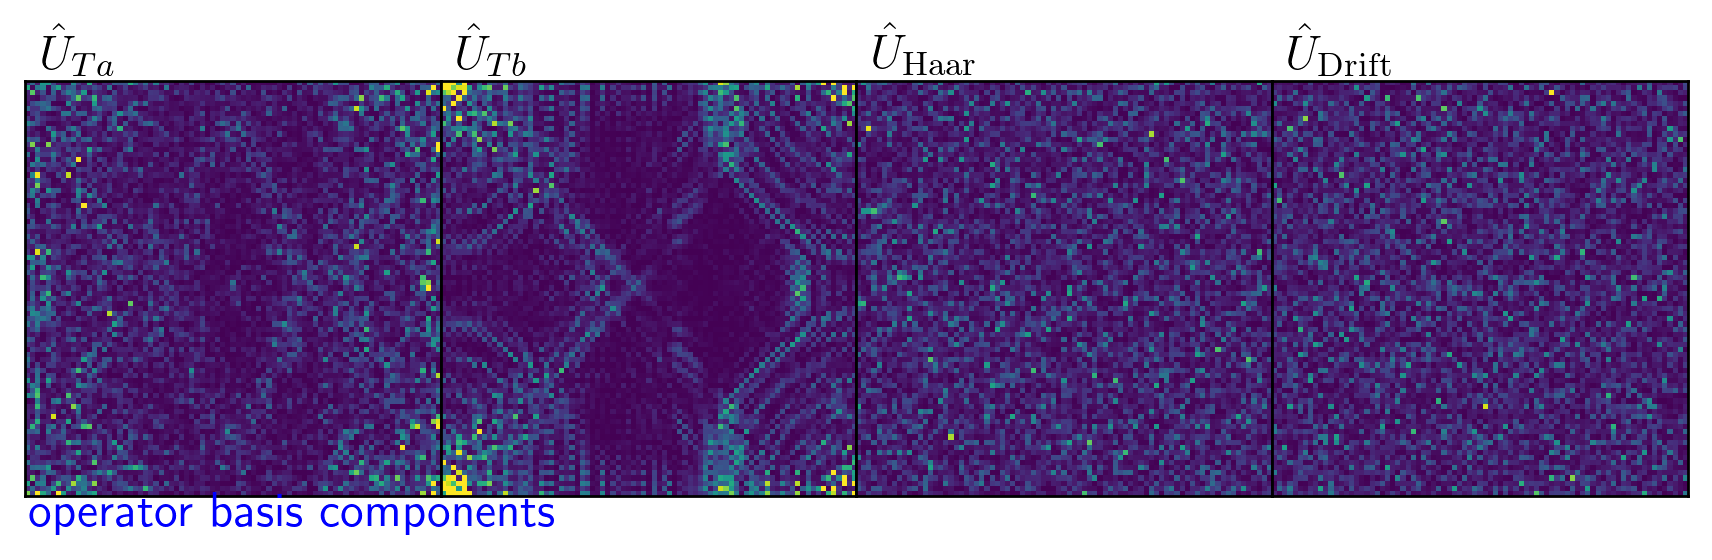

In [397]:
def plt4_Wvals(W_Ta,W_Tb,W_Tc,W_Td,l1=None,l2=None,l3=None,l4=None,balabel=None,ablabel=None,baselabel=None,ofile=None):
    N = W_Ta.shape[0]
    vmax = 1/np.sqrt(N)
    fig,axarr = plt.subplots(1,4,figsize=(7,2.3),dpi=250)
    plt.subplots_adjust(hspace=0,wspace=0,left=0.04,right=0.99,top=0.95,bottom =0.01)
    for j in range(4):
        axarr[j].set_xticks([])
        axarr[j].set_yticks([])
    axarr[0].imshow(np.absolute(W_Ta)**2,origin='lower',vmin=0,vmax=vmax)
    axarr[1].imshow(np.absolute(W_Tb)**2,origin='lower',vmin=0,vmax=vmax)
    axarr[2].imshow(np.absolute(W_Tc)**2,origin='lower',vmin=0,vmax=vmax)
    axarr[3].imshow(np.absolute(W_Td)**2,origin='lower',vmin=0,vmax=vmax)
    xl = 0.04; yl=1.03
    if (l1 != None):
        axarr[0].text(xl,yl,l1, transform = axarr[0].transAxes,fontsize=14)
    if (l2 != None):
        axarr[1].text(xl,yl,l2, transform = axarr[1].transAxes,fontsize=14)
    if (l3 != None):
        axarr[2].text(xl,yl,l3, transform = axarr[2].transAxes,fontsize=14)
    if (l4 != None):
        axarr[3].text(xl,yl,l4, transform = axarr[3].transAxes,fontsize=14)
    if (ablabel != None):
        axarr[0].text(-0.10,1.02,ablabel,transform = axarr[0].transAxes,fontsize=16)
    if (balabel != None):
        axarr[0].text(0.05,0.03,balabel, transform = axarr[0].transAxes,color='red',fontsize=15,ha='left')
    if (baselabel != None):
        axarr[0].text(0.01,-0.07,baselabel, transform = axarr[0].transAxes,color='blue',fontsize=14,ha='left')
    if (ofile != None):
        plt.savefig(ofile)
    plt.show()

ofile = froot + 'Wvals.png'
plt4_Wvals(Wvals_Ta,Wvals_Tb,Wvals_Ha,Wvals_var_1,l1=r'$\hat U_{Ta}$',l2=r'$\hat U_{Tb}$',\
           l3=r'$\hat U_{\rm Haar}$',l4=r'$\hat U_{\rm Drift}$',\
           baselabel='operator basis components',ablabel=None,ofile=ofile)  

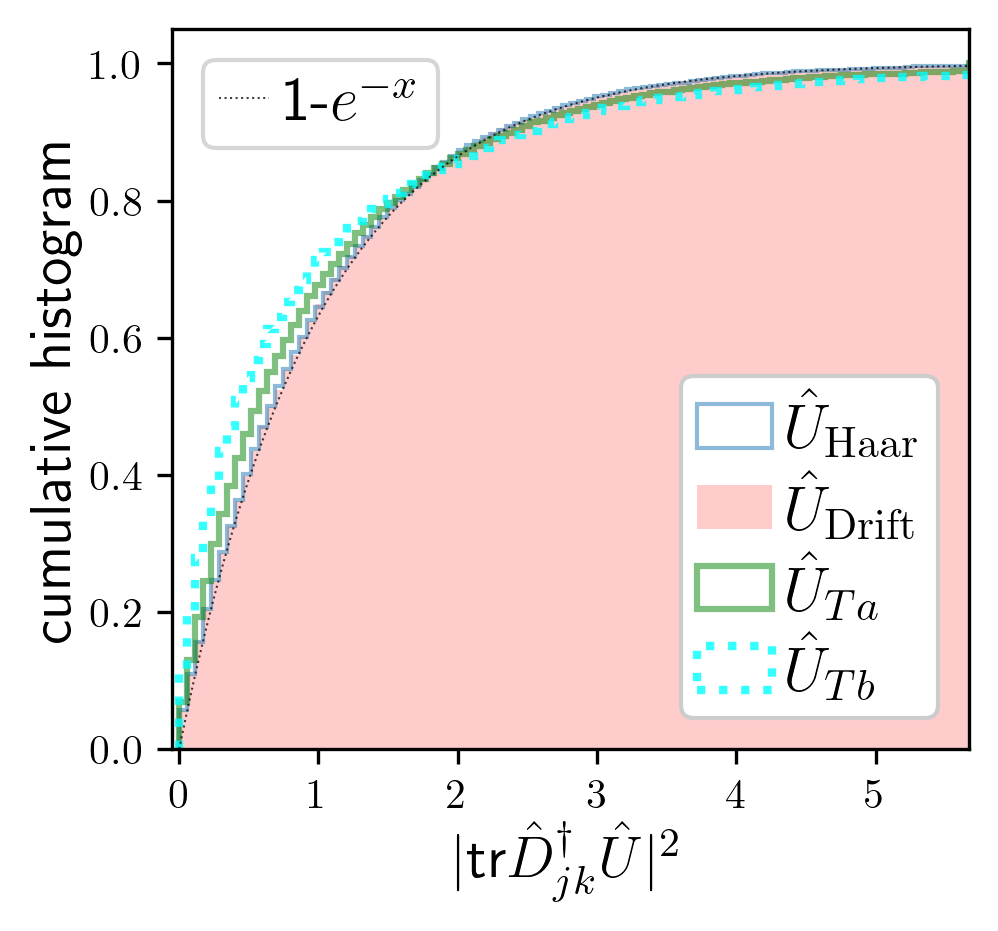

In [679]:
N = var_1.N
fac = N
mags_var_1 = np.ravel(np.absolute(Wvals_var_1)**2)*fac
mags_Ta    = np.ravel(np.absolute(Wvals_Ta)**2)*fac
mags_Tb    = np.ravel(np.absolute(Wvals_Tb)**2)*fac
mags_Ha    = np.ravel(np.absolute(Wvals_Ha)**2)*fac

xmin = 0; xmax=0.07*fac

fig,ax = plt.subplots(1,1,figsize=(3.2,3.0),dpi=300)
plt.subplots_adjust(hspace=0,wspace=0,left=0.15,right=0.98,top=0.98,bottom =0.18)
ax.set_xlim([-0.05,xmax])

bins_arr_1  = mkbinsarr(xmin,xmax,100,np.max(mags_var_1))
bins_arr_Ta = mkbinsarr(xmin,xmax,100,np.max(mags_Ta))
bins_arr_Tb = mkbinsarr(xmin,xmax,100,np.max(mags_Tb))
bins_arr_Ha = mkbinsarr(xmin,xmax,100,np.max(mags_Ha))

style1 = {'facecolor': 'blue',  'linewidth': 1, 'linestyle':'solid'}
style2 = {'facecolor': 'red',   'edgecolor': 'purple', 'linewidth': 0, 'linestyle':'solid'}
style3 = {'facecolor': 'green', 'edgecolor': 'green', 'linewidth': 1.5, 'linestyle':'solid'}
style4 = {'facecolor': 'cyan',  'edgecolor': 'cyan', 'linewidth': 2, 'linestyle':'dotted'}
    
ax.hist(mags_Ha   ,bins=bins_arr_Ha,density=True,alpha=0.5,cumulative=True,label=r'$\hat U_{\rm Haar}$',histtype='step',**style1)
ax.hist(mags_var_1,bins=bins_arr_1 ,density=True,alpha=0.2,cumulative=True,label=r'$\hat U_{\rm Drift}$',histtype='stepfilled',**style2)
ax.hist(mags_Ta   ,bins=bins_arr_Ta,density=True,alpha=0.5,cumulative=True,label=r'$\hat U_{Ta}$',histtype='step',**style3)
ax.hist(mags_Tb   ,bins=bins_arr_Tb,density=True,alpha=0.8,cumulative=True,label=r'$\hat U_{Tb}$',histtype='step',**style4)


first_legend = ax.legend(borderpad=0.25,handlelength=1.2,handletextpad=0.25,fontsize=15,labelspacing=0.2,framealpha=1)
ax.add_artist(first_legend)

xarr = np.linspace(xmin,xmax,100)
yarr = 1 - np.exp(-xarr)
ylabel = r'1-$e^{-x}$'
handles = []
llw, = ax.plot(xarr,yarr,'k:',lw=0.5,alpha=0.75,label=ylabel)
handles.append(llw)
second_legend = ax.legend(handles = handles, borderpad=0.25,handlelength=0.8,handletextpad=0.25,fontsize=15,labelspacing=0.2,\
                         loc = 'upper left')

ax.set_xlabel(r'$|$tr$\hat D_{jk}^\dagger \hat U|^2$',fontsize=14,labelpad=1)
ax.set_ylabel('cumulative histogram',fontsize=14,labelpad=2)

ofile = froot + 'wcumu.png'
plt.savefig(ofile)
plt.show()

In [680]:
perrs_short(mags_var_1,prefix='UD') 
perrs_short(mags_Ta   ,prefix='UTa')  
perrs_short(mags_Tb   ,prefix='UTb')     
perrs_short(mags_Ha   ,prefix='UHa')   

UD mean z  =1.000 += 0.012, std z  = 1.00
UD mean z2 =1.991 += 0.053, std z2 = 4.33
UD mean z3 =5.881 += 0.289, std z3 = 23.39
UTa mean z  =1.000 += 0.015, std z  = 1.23
UTa mean z2 =2.502 += 0.110, std z2 = 8.94
UTa mean z3 =11.577 += 1.353, std z3 = 109.57
UTb mean z  =1.000 += 0.021, std z  = 1.68
UTb mean z2 =3.821 += 0.298, std z2 = 24.15
UTb mean z3 =37.098 += 6.335, std z3 = 513.15
UHa mean z  =1.000 += 0.012, std z  = 1.00
UHa mean z2 =1.998 += 0.054, std z2 = 4.35
UHa mean z3 =5.929 += 0.285, std z3 = 23.06


(array([1.        , 1.99818112, 5.92926898]),
 array([ 0.99909015,  4.34668755, 23.05862175]),
 array([0.01233445, 0.05366281, 0.28467434]))

In [228]:
# a class for propagator meant for computing spacings 
class spacings_cls():
    def __init__(self,N,a,b,eps,mu,mup,taushift=0,phishift=0):
        self.N = N
        self.ntau = N*4
        self.a = a
        self.b = b
        self.eps = eps
        self.mu = mu
        self.mup= mup
        self.taushift = taushift
        self.phishift = phishift

        # compute propagator 
        w,vr,U = Husimi.U_prop2(N,self.ntau,a,b,eps,mu,mup,self.taushift,phishift=self.phishift) 
        self.w = w  # eigenvals
        self.vr = vr  # eigenvecs
        self.U = U  # non-drifted operator
        self.sarr = Husimi.compute_s(self.w)  # compute eigenphase spacing

        # h0 basis 
        w_h0,vr_h0 = Husimi.h0_eigs(self.N,self.a,self.b,self.eps) 
        #self.wsort = wsort
        self.w_h0 = w_h0  # eigenvals
        self.vr_h0 = vr_h0  # h0 basis, eigenvecs
        
        self.vr_j = np.identity(self.N)  # conventional basis 

        # Haar matrix
        self.U_Ha = scipy.stats.unitary_group.rvs(self.N) # single matrix, randomly chosen from Haar
        (w,vr)=np.linalg.eig(self.U_Ha)
        w_Ha,vr_Ha = Husimi.esort_phase(w,vr)
        self.w_Ha = w_Ha # eigenvals
        self.vr_Ha = vr_Ha  # eigenvecs
        self.sarr_Ha = Husimi.compute_s(self.w_Ha)

# a class to store information about a drifted propagator 
class sp_var_cls():
    def __init__(self,N,parms0,d_parms,tau0=0,nperiods=1,phishift=0):
        self.N = N
        self.parms0 = parms0
        self.d_parms = d_parms
        self.tau0 = tau0
        self.nperiods = nperiods
        self.phishift = phishift
        self.ntau = 4*N

        self.end_parms = self.parms0 + self.d_parms * 2*np.pi *self.nperiods
        
        # compute the propagator
        w_var,vr_var,U_var = Husimi.U_prop2_var(N,self.ntau,parms0,d_parms,tau0,nperiods,phishift=phishift)
        self.w = w_var
        self.vr = vr_var
        self.U = U_var
        self.sarr = Husimi.compute_s(self.w)  # compute eigenphase spacing

        #self.a0 = parms0[0]
        #self.b0 = parms0[1]
        #self.eps0 = parms0[2]
        #wsort,vr_h0 = Husimi.h0_eigs(self.N,self.a0,self.b0,self.eps0) 
        #self.vr_h0 = vr_h0  # h0 basis
        self.vr_j = np.identity(self.N)  # conventional basis 

        

In [659]:
# make the larger operators with bigger N
a = cla_Ta.a
eps = cla_Ta.eps
b = cla_Ta.b
mu = cla_Ta.mu
mup = cla_Ta.mup
N= 600
sp_Ta = spacings_cls(N,a,b,eps,mu,mup)  # takes like 5 minutes?

In [660]:
a = cla_Tb.a
eps = cla_Tb.eps
b = cla_Tb.b
mu = cla_Tb.mu
mup = cla_Tb.mup
N= sp_Ta.N
sp_Tb = spacings_cls(N,a,b,eps,mu,mup) 

In [661]:
parms0 = var_1.parms0
d_parms = var_1.d_parms
tau0 = var_1.tau0
nperiods = var_1.nperiods
N= sp_Ta.N
sp_var_1 = sp_var_cls(N,parms0,d_parms,tau0=tau0,nperiods=nperiods,phishift=0)
# this takes 10 minutes?

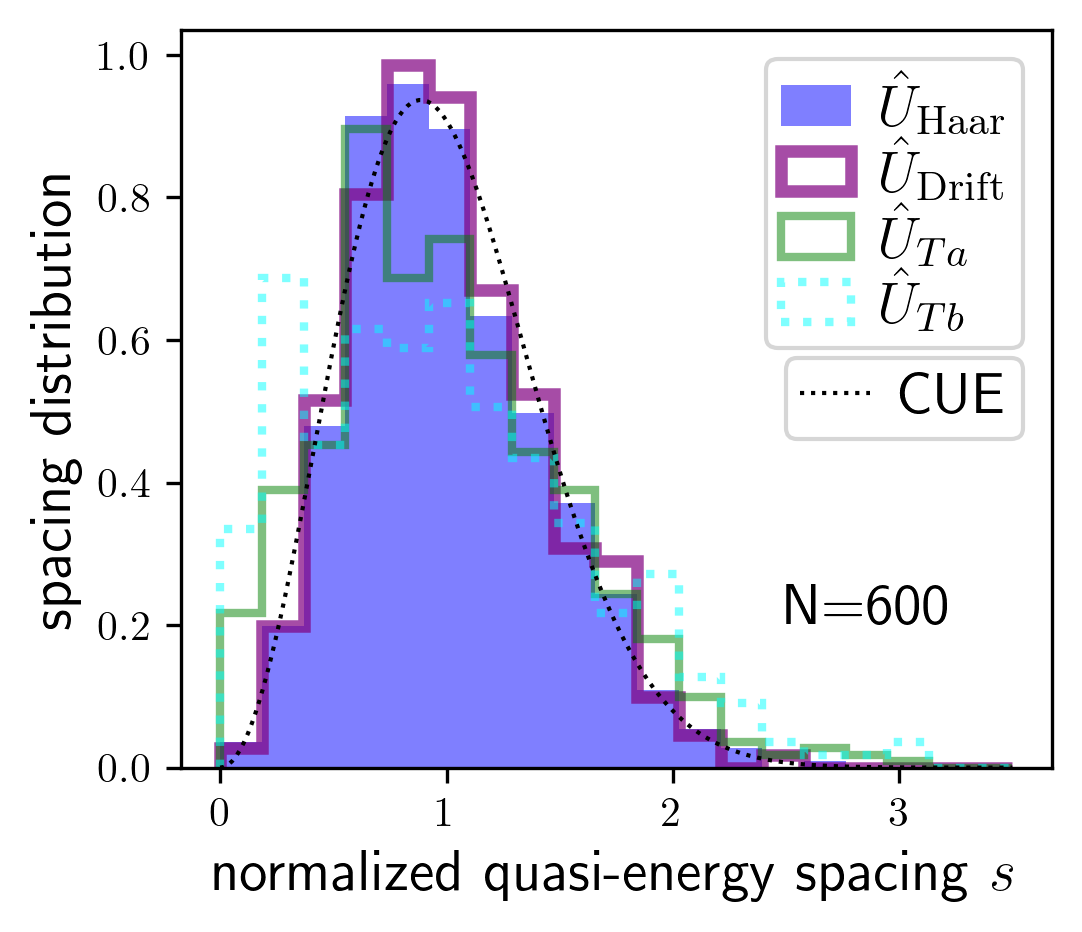

In [662]:
def p_COE(s):  # circular orthogonal ensemble, look at paper by Backer!
    p = (np.pi/2) * s * np.exp(-np.pi*s*s/4.0)  
    return p
# Same as Wigner Dyson GOE distribution 

def p_CUE(s):  # circular unitary ensemble 
    p = (32/np.pi**2) * s*s * np.exp(-4*s*s/np.pi)  
    return p

fig,ax = plt.subplots(1,1,figsize=(3.5,3),dpi=300)
plt.subplots_adjust(left=0.15,right=0.98,top=0.98,bottom=0.16)
lbins = np.linspace(0,3.5,20)
style1 = {'facecolor': 'blue', 'linewidth': 2, 'linestyle':'solid'}
style2 = {'facecolor': 'red',   'edgecolor': 'purple', 'linewidth': 3, 'linestyle':'solid'}
style3 = {'facecolor': 'green', 'edgecolor': 'green', 'linewidth': 2, 'linestyle':'solid'}
style4 = {'facecolor': 'cyan', 'edgecolor': 'cyan', 'linewidth': 2, 'linestyle':'dotted'}
ax.hist(sp_Ta.sarr_Ha,bins=lbins,alpha=0.5,label= r'$\hat U_{\rm Haar}$'    ,density=True,histtype='stepfilled',**style1)
ax.hist(sp_var_1.sarr,bins=lbins,alpha=0.7,label= r'$\hat U_{\rm Drift}$'   ,density=True,histtype='step',**style2)
ax.hist(sp_Ta.sarr   ,bins=lbins,alpha=0.5,label=r'$\hat U_{Ta}$',density=True,histtype='step',**style3)
ax.hist(sp_Tb.sarr   ,bins=lbins,alpha=0.5,label=r'$\hat U_{Tb}$',density=True,histtype='step',**style4)
first_legend = ax.legend(fontsize=14,borderpad=0.25,handlelength=1.2,handletextpad=0.5,labelspacing=0.03)
ax.add_artist(first_legend)
xarr = np.linspace(0,max(lbins),200)
y_COE = p_COE(xarr)
y_CUE = p_CUE(xarr)

handles = []
#llw,= ax.plot(xarr,y_COE,'m:',lw=0.5,label='COE'); handles.append(llw)
llw,= ax.plot(xarr,y_CUE,'k:',lw=1,label='CUE'); handles.append(llw)
second_legend = ax.legend(handles=handles, loc='center right',\
    fontsize=14,borderpad=0.25,handlelength=1.2,handletextpad=0.5,labelspacing=0.2)

ax.set_xlabel(r'normalized quasi-energy spacing $s$',fontsize=14)
ax.set_ylabel('spacing distribution',fontsize=14)
Nlabel = 'N={:0d}'.format(sp_var_1.N)
ax.text(2.5,0.2,Nlabel,fontsize=14)

ofile = froot + 'spacing.png'
plt.savefig(ofile)

plt.show()

# next,  doing frame potentials

In [458]:
# compute and return D_jk W D_jk^dagger for a single operator W
# Here Djk are displacement operators 
def DWDd(j,k,W):
    N = W.shape[0]
    D_jk        = Husimi.Displacement_op(N,j,k)
    D_jk_dagger = Husimi.Displacement_op_dagger(N,j,k)
    prod = np.matmul(D_jk,np.matmul(W,D_jk_dagger))
    return prod
    
# create the a list of D_jk W D_jk^dagger operators 
# over the HW group of all displacement ops (all j,k)
# return the list of unitaries 
def twirl_HW_list(W):
    N = W.shape[0]
    Ulist = np.zeros((N**2,N,N),dtype = complex)  # this is a big matrix !
    for j in range(N):
        for k in range(N):
            Ujk = DWDd(j,k,W)
            Ulist[j + N*k,:,:] = Ujk
    return Ulist

#N=51
#U_Ha = scipy.stats.unitary_group.rvs(N) # single matrix, random chosen from Haar  
#U_list = twirl_HW_list(U_Ha)

In [519]:
# compute list of unitaries twirl over HW group
a = cla_Ta.a
eps = cla_Ta.eps
b = cla_Ta.b
mu = cla_Ta.mu
mup = cla_Ta.mup
N=cla_Ta.N
cla_Ta_s = probs_cls(N,a,b,eps,mu,mup)
U_list_Ha =  twirl_HW_list(cla_Ta_s.U_Ha)
U_list_Ta =  twirl_HW_list(cla_Ta_s.U)

In [520]:
a = cla_Tb.a
eps = cla_Tb.eps
b = cla_Tb.b
mu = cla_Tb.mu
mup = cla_Tb.mup

N=cla_Ta_s.N
cla_Tb_s = probs_cls(N,a,b,eps,mu,mup)
U_list_Tb =  twirl_HW_list(cla_Tb_s.U)

In [521]:
parms0 = var_1.parms0
d_parms = var_1.d_parms
tau0 = var_1.tau0
nperiods = var_1.nperiods
N= cla_Ta_s.N
var_1_s = var_cls(N,parms0,d_parms,tau0=tau0,nperiods=nperiods,phishift=0)
U_list_var_1 =  twirl_HW_list(var_1_s.U)


In [522]:
U_list_Ta.shape  # this is big!

(6561, 81, 81)

In [663]:
# return a list Nz long of computed tr UV^dagger where pairs of ops U,V,
# are drawn randomly from the list of ops U_list
def rand_tr_list(U_list,Nz,seed=None):
    zlist = np.zeros(Nz)
    N_U = U_list.shape[0]
    if (seed != None):
        rs = np.random.RandomState(seed)
    for i in range(Nz):
        if (seed != None):
            j = scipy.stats.randint.rvs(0,N_U,random_state=rs)
            k = scipy.stats.randint.rvs(0,N_U,random_state=rs)
        else: 
            j = scipy.stats.randint.rvs(0,N_U)
            k = scipy.stats.randint.rvs(0,N_U)
        Uj = np.squeeze(U_list[j,:,:])
        Uk = np.squeeze(U_list[k,:,:])
        Uk_dagger = Uk.conjugate().T
        prod = np.matmul(Uj,Uk_dagger)
        z = (np.absolute(np.trace(prod)))**2  # note it is the square of the abs of the trace!
        zlist[i] = z
    return zlist

# return a list Nz long of computed tr UV^dagger where pairs of ops U,V,
# don't need to do this with random choices, we can just sum over N^2 possibilities 
def sum_list(U_list):
    N = U_list.shape[1]
    zlist = np.zeros(N*N)
    U0 = np.squeeze(U_list[0,:,:])  # is probably equal to W
    for k in range(N*N):
        Uk = np.squeeze(U_list[k,:,:])
        Uk_dagger = Uk.conjugate().T
        prod = np.matmul(U0,Uk_dagger)
        z = (np.abs(np.linalg.trace(prod)))**2  # note it is the square of the abs of the trace!
        zlist[k] = z
    return zlist 
    
# cummulative probability density distribution for exponential distribution 
def cdf_exp(x):  
    return 1- np.exp(-x)

# print stuff and return a list of stats from a list of values 
# calls cdf_exp()
def perrs(zlist,prefix=''):
    N_z = len(zlist)
    res = scipy.stats.kstest(zlist,cdf_exp);  res_2s = res.pvalue
    print(prefix,"twosided pvalue={:.3f}".format(res.pvalue))
    res = scipy.stats.kstest(zlist,cdf_exp,alternative='less');    res_l = res.pvalue  
    print(prefix,"lower pvalue={:.3f}".format(res.pvalue))
    res = scipy.stats.kstest(zlist,cdf_exp,alternative='greater'); res_g = res.pvalue
    print(prefix,"greater pvalue={:.3f}".format(res.pvalue))
    # If below 0.05 null hyp is rejected and that's bad

    mm = np.mean(zlist); sig = np.std(zlist); std_err = sig/np.sqrt(N_z)
    print(prefix,"mean z ={:.3f} += {:.3f}, std z = {:.2f}".format(mm, std_err, sig ))
    
    z2list = zlist**2  # take the square for computing means k=2
    mm_2 = np.mean(z2list); sig_2 = np.std(z2list); std_err_2 = sig_2/np.sqrt(N_z)
    print(prefix,"mean z2 ={:.3f} += {:.3f}, std z2 = {:.2f}".format(mm_2, std_err_2, sig_2 ))
    
    z3list = zlist**3  # take the cube for computing means k=3
    mm_3 = np.mean(z3list); sig_3 = np.std(z3list); std_err_3 = sig_3/np.sqrt(N_z)
    print(prefix,"mean z3 ={:.3f} += {:.3f}, std z3 = {:.2f}".format(mm_3, std_err_3, sig_3 ))
    return np.array([ res_2s, res_l, res_g, mm, std_err, sig, mm_2, std_err_2,sig_2,mm_3, std_err_3,sig_3])
    # res_2s is a twosided pvalue, from ks test with exponential distribution 
    # res_l is a lower pvalue
    # rels_g is a greater pvalue
    # mm is the mean
    # std_err is the standard error
    # sig is the standard deviation computed from the sample 
    # mm_2 is the mean of z^2
    # std_err_2 is the standard error of z^2
    # sig_2 is the standard deviation from the sample of z^2
    print("")



In [524]:
def tw_hist(fac,zlist_Ta,zlist_Tb,zlist_Ha,zlist_var_1,ofile):
    #fac = 5
    xmin = 0; xmax=1*fac

    fig,ax = plt.subplots(1,1,figsize=(3.2,3.0),dpi=300)
    plt.subplots_adjust(hspace=0,wspace=0,left=0.15,right=0.98,top=0.98,bottom =0.15)
    ax.set_xlim([-0.05,xmax])

    bins_arr_1  = mkbinsarr(xmin,xmax,100,np.max(zlist_var_1))
    bins_arr_Ta = mkbinsarr(xmin,xmax,100,np.max(zlist_Ta))
    bins_arr_Tb = mkbinsarr(xmin,xmax,100,np.max(zlist_Tb))
    bins_arr_Ha = mkbinsarr(xmin,xmax,100,np.max(zlist_Ha))

    style1 = {'facecolor': 'blue',  'linewidth': 1.5, 'linestyle':'solid'}
    style2 = {'facecolor': 'red',   'edgecolor': 'purple', 'linewidth': 0, 'linestyle':'solid'}
    style3 = {'facecolor': 'green', 'edgecolor': 'green', 'linewidth': 2, 'linestyle':'solid'}
    style4 = {'facecolor': 'cyan',  'edgecolor': 'cyan', 'linewidth': 2.5, 'linestyle':'dotted'}
    
    ax.hist(zlist_Ha   ,bins=bins_arr_Ha,density=True,alpha=0.5,cumulative=True,label=r'$\hat U_{\rm Haar}$',histtype='step',**style1)
    ax.hist(zlist_var_1,bins=bins_arr_1 ,density=True,alpha=0.2,cumulative=True,label=r'$\hat U_{\rm Drift}$',histtype='stepfilled',**style2)
    ax.hist(zlist_Ta   ,bins=bins_arr_Ta,density=True,alpha=0.5,cumulative=True,label=r'$\hat U_{Ta}$',histtype='step',**style3)
    ax.hist(zlist_Tb   ,bins=bins_arr_Tb,density=True,alpha=0.8,cumulative=True,label=r'$\hat U_{Tb}$',histtype='step',**style4)

    first_legend = ax.legend(borderpad=0.25,handlelength=1.2,handletextpad=0.25,fontsize=15,labelspacing=0.2,framealpha=1)
    ax.add_artist(first_legend)

    xarr = np.linspace(xmin,xmax,100)
    yarr = 1 - np.exp(-xarr)
    ylabel = r'1-$e^{-x}$'
    handles = []
    llw, = ax.plot(xarr,yarr,'k-',lw=0.5,alpha=0.7,label=ylabel)
    handles.append(llw)
    second_legend = ax.legend(handles = handles, borderpad=0.25,handlelength=0.8,handletextpad=0.25,fontsize=15,labelspacing=0.05,\
                         loc = 'upper left')

    xlab = r'$|$tr$ \hat V \hat W^\dagger|^2$: $\hat V,\hat W\! \in $ ' + 'twirlset'  #+ '\n' 
    xlab +=  r'($\bar G_{\rm HW} , \hat U)$'
    ax.set_xlabel(xlab,fontsize=14,labelpad=1,loc='right')
    ax.set_ylabel('cumulative histogram',fontsize=14,labelpad=2)

    if (len(ofile)>2):
    
        plt.savefig(ofile)
    plt.show()

#fac = 5
#ofile = froot + 'tw_framep.png'
#tw_hist(fac,zlist_Ta,zlist_Tb,zlist_Ha,zlist_var_1,ofile)

In [525]:
xi = 0
szlist_Ha = sum_list(U_list_Ha)
parr_Ha = perrs(szlist_Ha[xi:])
szlist_Ta = sum_list(U_list_Ta)
parr_Ta = perrs(szlist_Ta[xi:])
szlist_Tb = sum_list(U_list_Tb)
parr_Tb = perrs(szlist_Tb[xi:])
szlist_var_1 = sum_list(U_list_var_1)
parr_var_1 = perrs(szlist_var_1[xi:])
# the first one in the list is a problem! you get trace of I which is N^2k  and when normalized you get N^2(k-1)
# and this explains why we had such large values in the frame potential 


 twosided pvalue=0.010
 lower pvalue=0.913
 greater pvalue=0.005
 mean z =1.968 += 1.000, std z = 80.99
 mean z2 =6562.927 += 6560.500, std z2 = 531400.47
 mean z3 =43046726.900 += 43043440.374, std z3 = 3486518670.31
 twosided pvalue=0.000
 lower pvalue=0.000
 greater pvalue=0.999
 mean z =2.502 += 1.005, std z = 81.39
 mean z2 =6630.730 += 6560.648, std z2 = 531412.47
 mean z3 =43076456.390 += 43043440.950, std z3 = 3486518716.96
 twosided pvalue=0.000
 lower pvalue=0.000
 greater pvalue=0.940
 mean z =3.821 += 1.022, std z = 82.75
 mean z2 =6862.564 += 6561.642, std z2 = 531492.99
 mean z3 =43203516.154 += 43043505.935, std z3 = 3486523980.75
 twosided pvalue=0.001
 lower pvalue=0.571
 greater pvalue=0.000
 mean z =1.991 += 1.000, std z = 80.99
 mean z2 =6562.999 += 6560.500, std z2 = 531400.47
 mean z3 =43046726.946 += 43043440.374, std z3 = 3486518670.30


In [643]:
def print_parr(parr,N):
    mm1 = parr[3]
    mm2 = parr[6]
    mm3 = parr[9]
    mm1_haar = haar_val(1,N) # (k+1)! N^k-1
    mm2_haar = haar_val(2,N) #  12*6*N  
    mm3_haar = haar_val(3,N)  # 50*10*10*N*N
    print('{:.2f} {:.2f} {:.2f}'.format( mm1/mm1_haar,  mm2/mm2_haar, mm3/mm3_haar))
    #([ res_2s, res_l, res_g, mm, std_err, sig, mm_2, std_err_2,sig_2,mm_3, std_err_3,sig_3])

def haar_val(k,N):
    fac = scipy.special.factorial(2*k) * k*k    # try this function and see how it works, not too bad for up to k=3
    z = fac*np.power(N,k-1) 
    return z

print_parr(parr_Ha,cla_Tb_s.N)
print_parr(parr_Ta,cla_Tb_s.N)
print_parr(parr_Tb,cla_Tb_s.N)
print_parr(parr_var_1,cla_Tb_s.N)

0.98 0.84 1.01
1.25 0.85 1.01
1.91 0.88 1.02
1.00 0.84 1.01


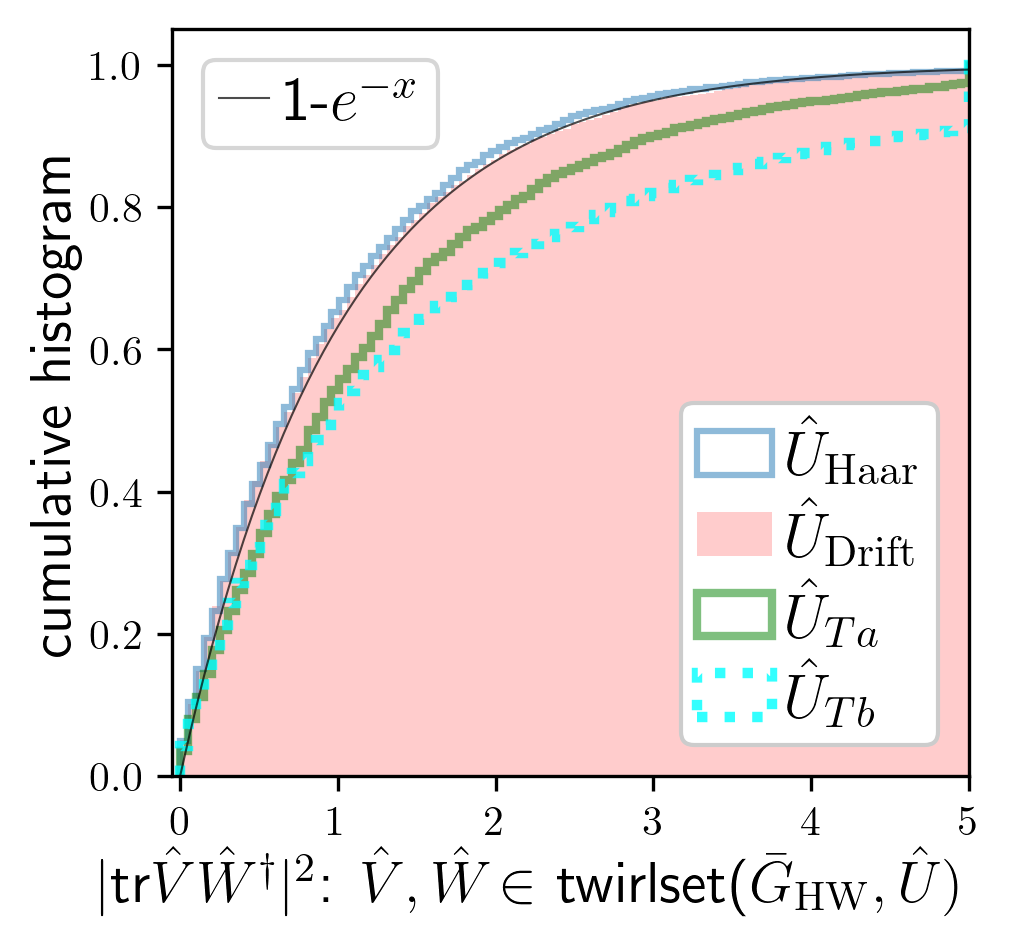

In [527]:
fac = 5
ofile = froot + 'tw_framep2.png'
tw_hist(fac,szlist_Ta,szlist_Tb,szlist_Ha,szlist_var_1,ofile)

In [635]:
# create a concatenation of m twirl sets  of random unitaries
# this does not work at all, gives a 1 design in limit of high m but other frame designs are not well behaved 
def mk_Ha_m(N,m,seed=None):
    if (seed != None):
        rs = np.random.RandomState(seed)
        U_Ha = scipy.stats.unitary_group.rvs(N,random_state=rs) # single matrix, randomly chosen from Haar
    else:
        U_Ha = scipy.stats.unitary_group.rvs(N)
    U_list = twirl_HW_list(U_Ha)
    Ucat = U_list
    for k in range(m-1):
        if (seed != None):
            U_Ha = scipy.stats.unitary_group.rvs(N,random_state=rs) # single matrix, randomly chosen from Haar
        else:
            U_Ha = scipy.stats.unitary_group.rvs(N) # single matrix, randomly chosen from Haar
        U_list = twirl_HW_list(U_Ha)
        Ucat = np.concatenate((Ucat,U_list))
    return Ucat



In [645]:
N=51
m=2
Ubig = mk_Ha_m(N,m,seed=5)
print(Ubig.shape)

Nz=20000
zlist = rand_tr_list(Ubig,Nz,seed=13)
parr = perrs(zlist)

(5202, 51, 51)
 twosided pvalue=0.000
 lower pvalue=0.000
 greater pvalue=0.009
 mean z =1.545 += 0.260, std z = 36.78
 mean z2 =1355.204 += 676.452, std z2 = 95664.79
 mean z3 =3519264.468 += 1759452.808, std z3 = 248824202.31


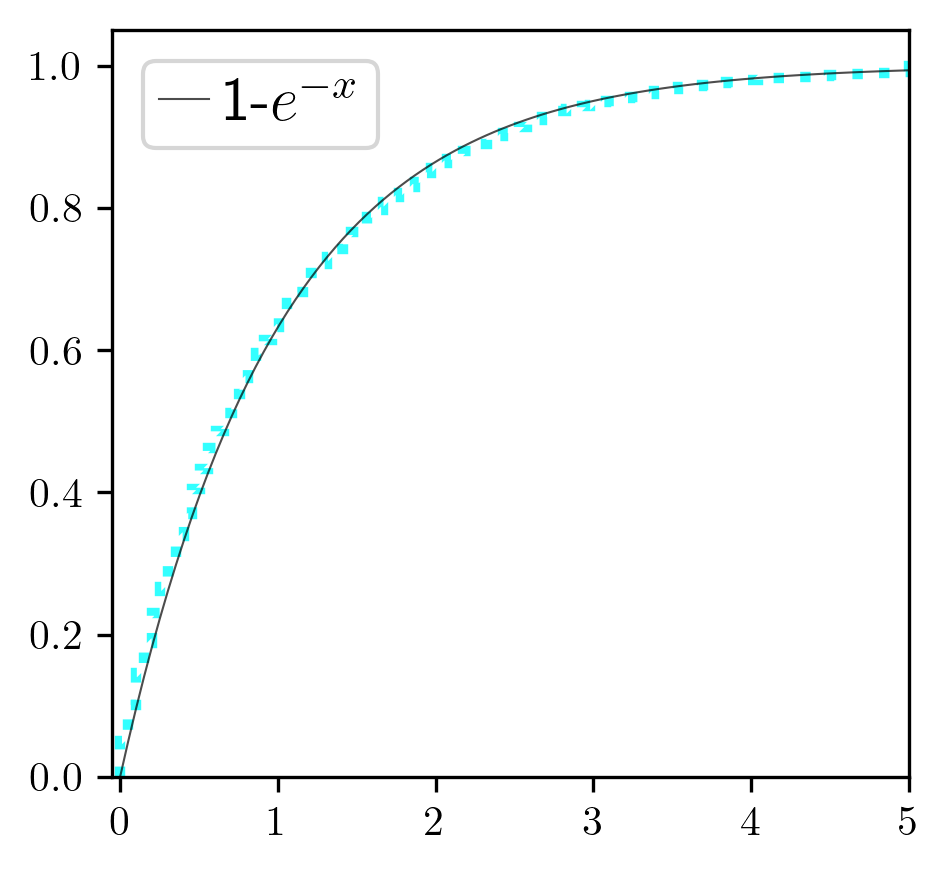

In [657]:

def plt1zhist(zlist):
    xmax = 5; xmin = 0
    bins_arr  = mkbinsarr(0,xmax,100,np.max(zlist))
    fig,ax = plt.subplots(1,1,figsize=(3.2,3.0),dpi=300)
    plt.subplots_adjust(hspace=0,wspace=0,left=0.15,right=0.98,top=0.98,bottom =0.15)
    ax.set_xlim([-0.05,xmax])
    style4 = {'facecolor': 'cyan',  'edgecolor': 'cyan', 'linewidth': 2.5, 'linestyle':'dotted'}
    ax.hist(zlist   ,bins=bins_arr,density=True,alpha=0.8,cumulative=True,label=r'$$',histtype='step',**style4)
    xarr = np.linspace(xmin,xmax,100)
    yarr = 1 - np.exp(-xarr)
    ylabel = r'1-$e^{-x}$'
    handles = []
    llw, = ax.plot(xarr,yarr,'k-',lw=0.5,alpha=0.7,label=ylabel)
    handles.append(llw)
    second_legend = ax.legend(handles = handles, borderpad=0.25,handlelength=0.8,handletextpad=0.25,fontsize=15,labelspacing=0.05,\
                         loc = 'upper left')

    plt.show()

plt1zhist(zlist)
#print_parr(parr,N)

In [650]:
def double_twirl_m(N,seed=None):
    if (seed != None):
        rs = np.random.RandomState(seed)
        U_Ha = scipy.stats.unitary_group.rvs(N,random_state=rs) # single matrix, randomly chosen from Haar
    else:
        U_Ha = scipy.stats.unitary_group.rvs(N)
    U_list = twirl_HW_list(U_Ha)
    Ucat = np.zeros((0,N,N))
    for k in range(N*N):
        U = np.squeeze(U_list[k,:,:])
        Tw_list = twirl_HW_list(U_Ha)
        Ucat = np.concatenate((Ucat,Tw_list))
    return Ucat

In [655]:
N=15
Ubig = double_twirl_m(N,seed=None)
print(Ubig.shape)

(50625, 15, 15)


In [654]:
11**4

14641

 twosided pvalue=0.000
 lower pvalue=0.000
 greater pvalue=0.000
 mean z =1.940 += 0.100, std z = 14.09
 mean z2 =202.304 += 22.453, std z2 = 3175.30
 mean z3 =45000.278 += 5052.094, std z3 = 714473.94


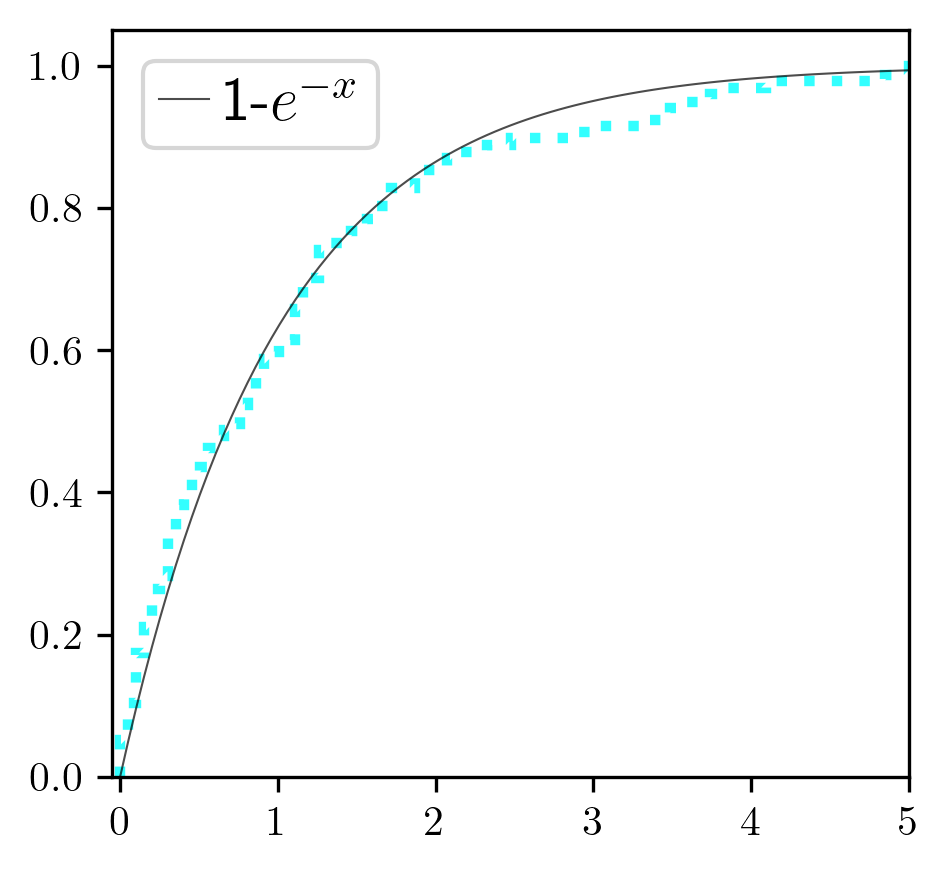

In [658]:
Nz=20000
zlist = rand_tr_list(Ubig,Nz,seed=13)
parr = perrs(zlist)
plt1zhist(zlist)